# Time-Contrastive Learning for discourse change detection

TCL code is based on the simulation described in Hyvarinen and Morioka, Unsupervised Feature Extraction by
Time-Contrastive Learning and Nonlinear ICA. NIPS 2016. Original TCL code is available at https://github.com/hirosm/TCL

In [66]:
import os
import os.path
import time
from datetime import datetime
import sys
import copy
import pickle
import shutil
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import norm
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from torch import nn
from sentence_transformers import SentenceTransformer, util, models

## Generating synthetic datasets for testing the method

In [2]:
# Lemmatized YLE article data that is filtered to include 12 selected categories is available at Puhti at
# /scratch/project_2003138/datasets/yle/cluster_12_cats_lemmas.json

In [3]:
# path to data
path = '/home/local/mclipsan/Documents/Internship/Code/data/yle_lemmatized/cluster_12_cats_lemmas.json'
df = pd.read_json(path)

In [4]:
# Below code for generating synthetic datasets is take from https://github.com/ruathudo/detangling-discourses
# data_sampling.ipynb

In [5]:
def linear_pattern(n=1, start=0, stop=100, change_rate=1):
    """
    Sampling up pattern, start and end in random points
    """
    # print(lower_p, upper_p)
    # change_points = np.array([0, lower_p, upper_p, timeline], dtype=int)
    x = np.arange(start, stop)
    # normalize x to range 0-1
    y = (x - start) / (stop - start)
    freq_rates = n + y * n * change_rate
    
    return freq_rates

def sigmoid_pattern(n=1, start=0, stop=100, change_rate=1):
    x = np.arange(start, stop)
    mid = int((stop - start) / 2)
    y = 1 / (1 + np.exp(-0.1* (x-mid) ))
    y = (y - y.min()) / (y.max() - y.min())
    
    freq_rates = n + y * n * change_rate
    return freq_rates

def flat_pattern(n=1, start=0, stop=100):
    freq_rates = np.ones(stop-start) * n
    return freq_rates


def bell_pattern(n=1, start=0, stop=100, change_rate=1, std=0):
    sample_list = []
    time_range = stop - start
    
    x = np.arange(start, stop)
    mu = int(time_range / 2)
    
    std = std if std else int(time_range / 5)
    y = norm.pdf(np.arange(time_range), mu, std)
    # scale 0-1
    y = (y - y.min()) / (y.max() - y.min())
    # add n docs
    freq_rates = n + y * n * change_rate
    
    return freq_rates

In [6]:
def sample_val_pattern(data, time_freqs, change_points, n_doc):
    # calculate the docs_num based on the total docs and its freqs distribution
    docs_num = (n_doc * time_freqs).astype(int)
    sample = data.sample(n_doc)
    sample['time'] = -1
        
    cur = 0
    for i, n in enumerate(docs_num):
        sample.iloc[cur:cur+n, sample.columns.get_loc("time")] = i
        cur += n
    
    # because the freq is converted to int so some articles will remain -1 for time, we need to prunt those
    sample = sample[sample['time'] > -1]
    
    return sample, change_points

In [7]:
def sample_pattern(pattern, timeline=100, change_rate=0.01):
    sample = None
    
    if pattern == 'up':
        lower_p = np.random.randint(low=1, high=timeline-30)
        upper_p = np.random.randint(low=lower_p+20, high=timeline)
        
        # f1, f2, f3 [-1] is the start of freqs ratio for the pattern as the chaning variable
        f1 = flat_pattern(1, start=0, stop=lower_p)
        f2 = sigmoid_pattern(f1[-1], start=lower_p, stop=upper_p, change_rate=change_rate)
        f3 = flat_pattern(f2[-1], start=upper_p, stop=timeline)
        
        # the frequency ratio 
        time_freqs = np.concatenate((f1, f2, f3))
        time_freqs = time_freqs / time_freqs.sum()

        change_points = np.array([lower_p, upper_p])
        
    elif pattern == 'down':
        lower_p = np.random.randint(low=1, high=timeline-30)
        upper_p = np.random.randint(low=lower_p+20, high=timeline)
        
        f1 = flat_pattern(1, start=0, stop=lower_p)
        f2 = sigmoid_pattern(f1[-1], start=lower_p, stop=upper_p, change_rate=-change_rate)
        f3 = flat_pattern(f2[-1], start=upper_p, stop=timeline)
        
        # the frequency ratio 
        time_freqs = np.concatenate((f1, f2, f3))
        time_freqs = time_freqs / time_freqs.sum()

        change_points = np.array([lower_p, upper_p])
        
    elif pattern == 'spike_up':
        n_point = np.random.randint(1, 5)
        invalid = True
        
        while invalid:
            change_points = np.sort(np.random.choice(range(5, timeline - 5), n_point, replace=False))
            diff = np.diff(change_points)
            invalid = len(np.where(diff < 10)[0])
            
        change_rates = np.random.uniform(0.3, change_rate, n_point)
        #print(change_points)
        cur_p = 0
        cur_n = 1
        
        time_freqs = []
        
        for i, p in enumerate(change_points):
            #print(cur_p, p - 2)
            f1 = flat_pattern(cur_n, start=cur_p, stop=p-2)
            cur_n = f1[-1]
            f2 = bell_pattern(cur_n, start=p-2, stop=p+3, change_rate=change_rates[i], std=0.1)
            cur_n = f2[-1]
            
            time_freqs.append(f1)
            time_freqs.append(f2)
            
            cur_p = p + 3
            
            if i == len(change_points) - 1:
                f3 = flat_pattern(cur_n, start=cur_p, stop=timeline)
                time_freqs.append(f3)

        time_freqs = np.concatenate(time_freqs)
        time_freqs = time_freqs / time_freqs.sum()
        
    elif pattern == 'spike_down':
        n_point = np.random.randint(1, 5)
        invalid = True
        # generate n points with min distance 10
        while invalid:
            change_points = np.sort(np.random.choice(range(5, timeline - 5), n_point, replace=False))
            diff = np.diff(change_points)
            invalid = len(np.where(diff < 10)[0])
            
        change_rates = np.random.uniform(0.3, change_rate, n_point)
        cur_p = 0
        cur_n = 1
        
        time_freqs = []
        
        for i, p in enumerate(change_points):

            f1 = flat_pattern(cur_n, start=cur_p, stop=p-2)
            cur_n = f1[-1]
            f2 = bell_pattern(cur_n, start=p-2, stop=p+3, change_rate=-change_rates[i], std=0.1)
            cur_n = f2[-1]
            
            time_freqs.append(f1)
            time_freqs.append(f2)
            
            cur_p = p + 3
            
            if i == len(change_points) - 1:
                f3 = flat_pattern(cur_n, start=cur_p, stop=timeline)
                time_freqs.append(f3)
            
        time_freqs = np.concatenate(time_freqs)
        time_freqs = time_freqs / time_freqs.sum()
        
    elif pattern == 'up_down':
        lower_p = np.random.randint(low=1, high=timeline-20)
        upper_p = np.random.randint(low=lower_p+10, high=timeline)
        
        f1 = flat_pattern(1, start=0, stop=lower_p)
        f2 = bell_pattern(f1[-1], start=lower_p, stop=upper_p, change_rate=change_rate)
        f3 = flat_pattern(f2[-1], start=upper_p, stop=timeline)
        
        # the frequency ratio 
        time_freqs = np.concatenate((f1, f2, f3))
        time_freqs = time_freqs / time_freqs.sum()
        
        mid_p = int(lower_p + (upper_p - lower_p) / 2)
        change_points = np.array([lower_p, mid_p, upper_p])
        
    elif pattern == 'down_up':
        lower_p = np.random.randint(low=1, high=timeline-20)
        upper_p = np.random.randint(low=lower_p+10, high=timeline)
        
        f1 = flat_pattern(1, start=0, stop=lower_p)
        f2 = bell_pattern(f1[-1], start=lower_p, stop=upper_p, change_rate=-change_rate)
        f3 = flat_pattern(f2[-1], start=upper_p, stop=timeline)
        
        # the frequency ratio 
        
        time_freqs = np.concatenate((f1, f2, f3))
        time_freqs = time_freqs / time_freqs.sum()

        mid_p = int(lower_p + (upper_p - lower_p) / 2)
        change_points = np.array([lower_p, mid_p, upper_p])
        
    else:
        time_freqs = flat_pattern(1, start=0, stop=timeline)
        time_freqs = time_freqs / time_freqs.sum()
        change_points = np.empty(shape=(0,))
        
    return time_freqs, change_points.astype(int)

In [8]:
def create_test_samples(df, n_samples=100, min_doc=50, max_doc=100, frac=0.99, timeline=100, change_rates=[0.5, 1]):
    categories = df['category'].unique()
    
    samples = []   # list article ids
    tracker = pd.DataFrame(columns=['category', 'pattern', 'pivots'])
    # sample_pivots = []  # list of pivots index in timeline, need to map with ids
    patterns = ['up', 'down', 'up_down', 'down_up', 'spike_up', 'spike_down']
    # events = np.random.choice(patterns, n_samples, p=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4])
    # patterns = ['spike_down']
    
    g = df.groupby(['category'])
    
    for _ in range(n_samples):
        # select random category as the target
        # And the rest as noise
        cat = np.random.choice(categories)
        pattern = np.random.choice(patterns)
        change_rate = np.random.uniform(*change_rates)
        df_sample = []
        
        for c in categories:
            if c == cat:
                freqs, pivots = sample_pattern(pattern, timeline=timeline, change_rate=change_rate)
            else:
                freqs, _ = sample_pattern('stable', timeline=timeline, change_rate=change_rate)
        
            # get n_doc, which is random between min and max but not exceed the total docs in cluster
            df_cat = g.get_group(c)[['id', 'category', 'title', 'body']]
            df_len = len(df_cat)
            n_doc = np.random.randint(min_doc, max_doc)
            n_doc = min(n_doc, df_len)
        
            # calculate the docs_num based on the total docs and its freqs distribution
            docs_num = (n_doc * freqs).astype(int)
            sample = df_cat.sample(n_doc)
            sample['time'] = -1
 
            #print(sample.head())
            
            # assign the sampled time points to the docs
            cur = 0
            for i, n in enumerate(docs_num):
                sample.iloc[cur:cur+n, sample.columns.get_loc("time")] = i
                cur += n

            # because the freq is converted to int, so the n_doc > docs_num. so some articles will remain -1 for time, we need to prunt those
            sample = sample[sample['time'] > -1]
            df_sample.append(sample)
            
        df_sample = pd.concat(df_sample, ignore_index=True)
        #df_sample = df_sample.sample(frac=frac)
        samples.append(df_sample)
        
        tracker = tracker.append({'category':cat, 'pattern': pattern, 'pivots': pivots}, ignore_index=True)
        
    return samples, tracker

In [9]:
def visualize_trending(df):
    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    for name, group in df.groupby(['category']):
        g = group.groupby(['time'])['id'].count()
        ax.plot(g.index, g.values, label=name)
    
    ax.set(xlabel='time', ylabel='Numbers')
    ax.legend()
    ax.grid()

    plt.show()

In [10]:
# Generates n samples for testing purposes
n = 5
test_samples, tracker = create_test_samples(df, n_samples=n, timeline=100, min_doc=800, max_doc=1500, frac=0.99, change_rates=[0.5, 1])

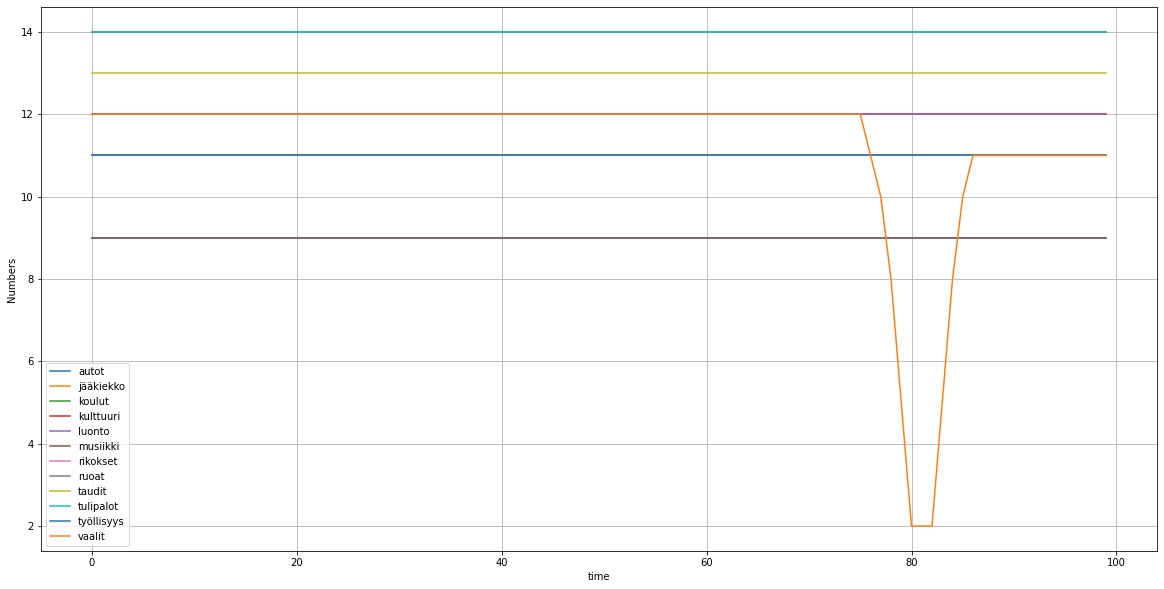

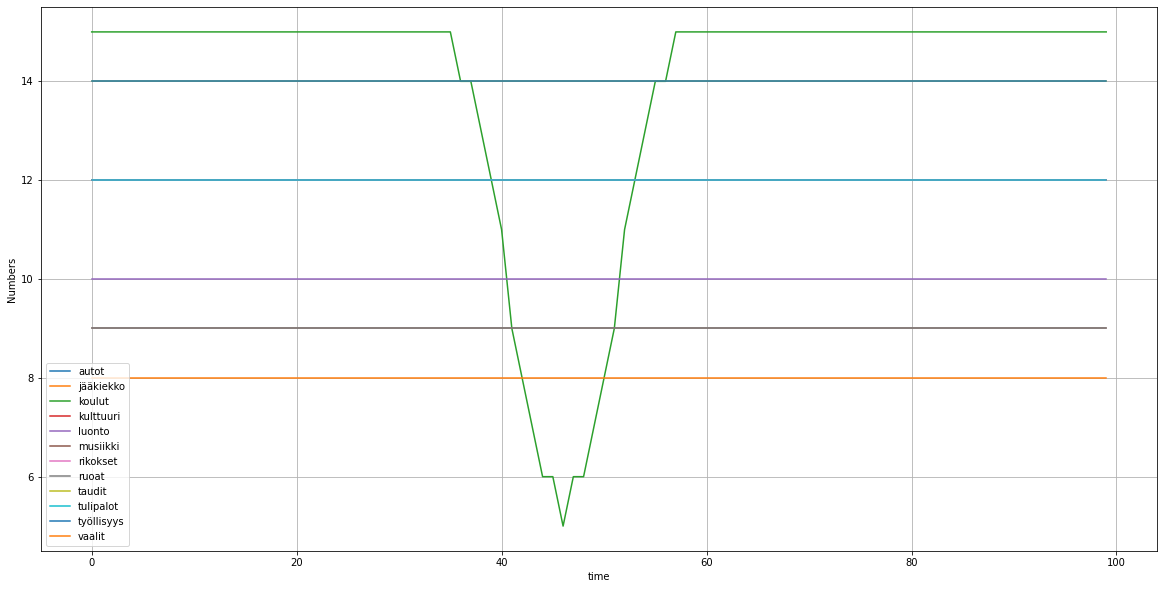

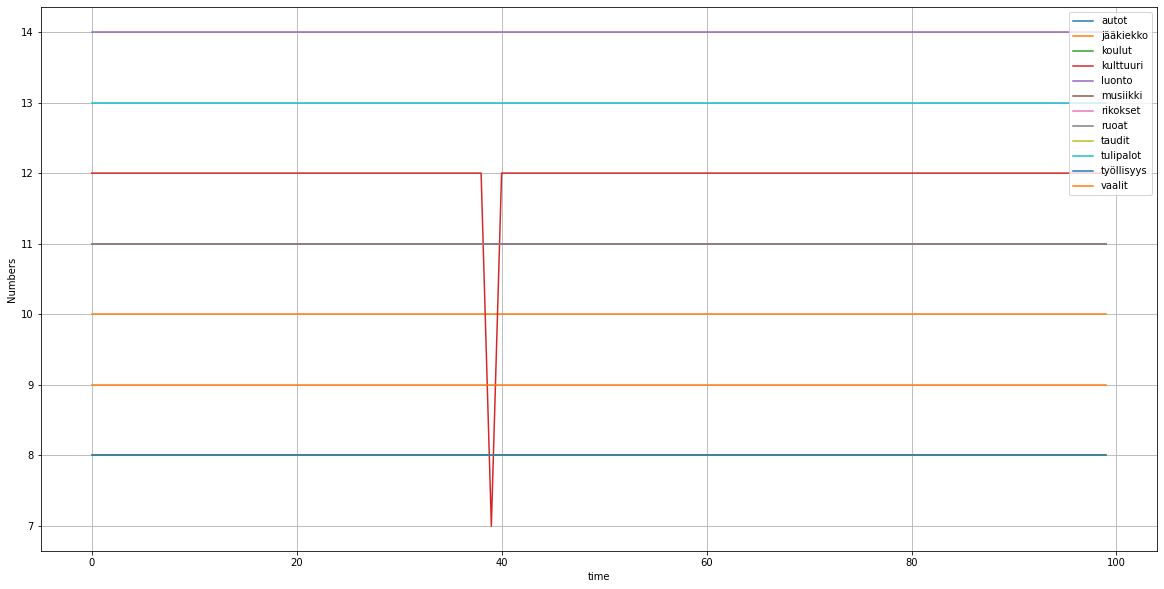

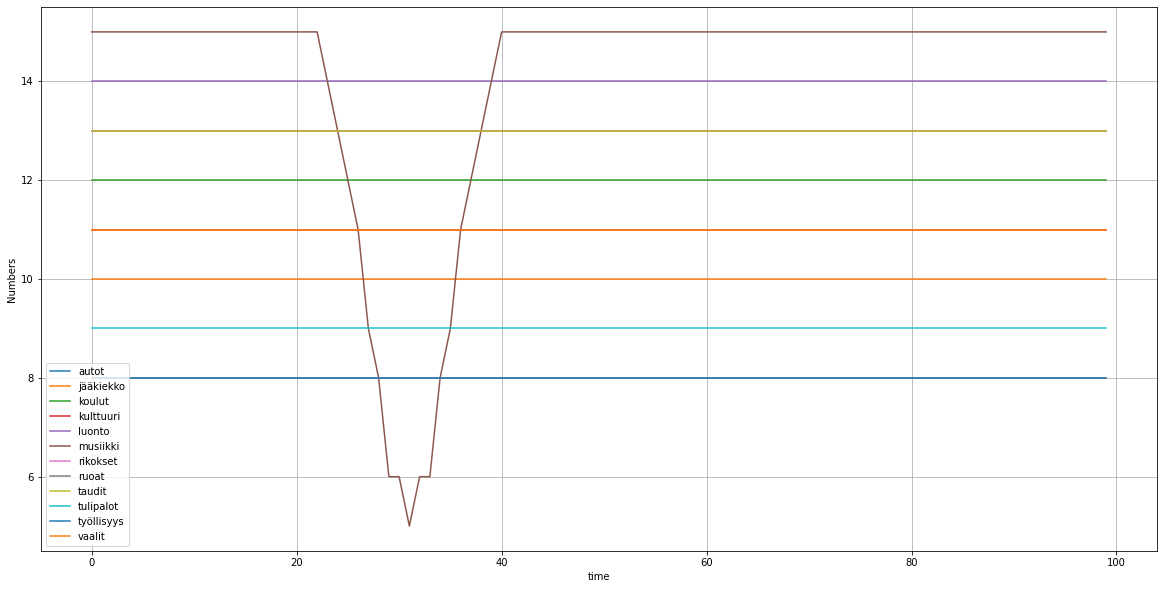

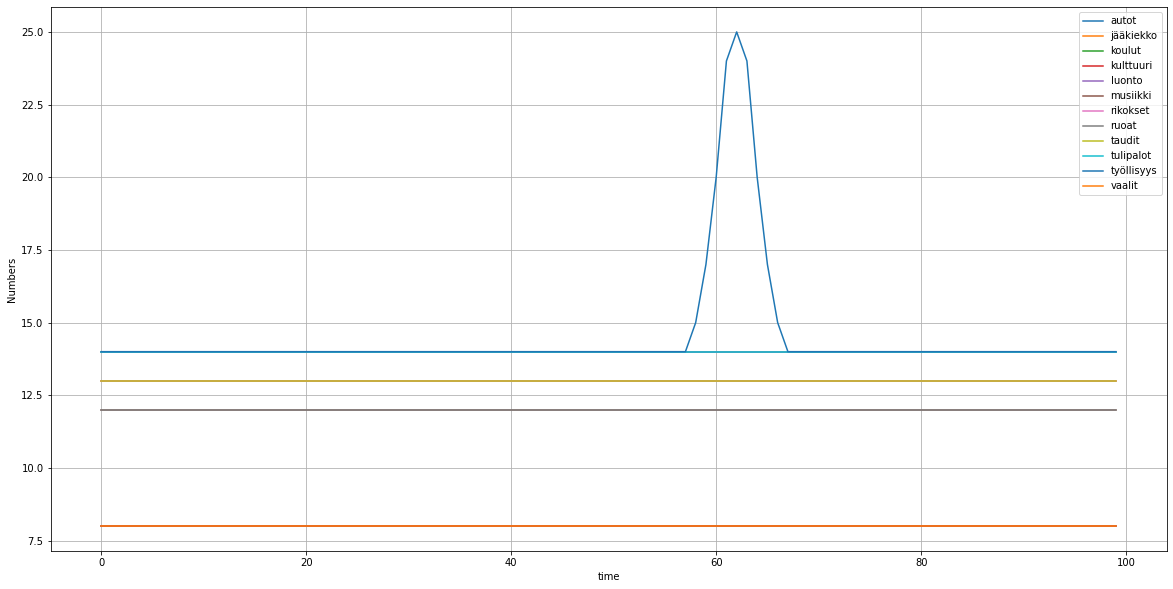

In [11]:
# Visualize discourse trends in generated data
for dataframe in test_samples:
    visualize_trending(dataframe)

In [163]:
# Select one dataframe for training and one for testing
train_df = test_samples[0]
test_df = test_samples[1]

In [164]:
def preprocess_df(df):
    
    # Join article titles and text body
    df['body'] = df['title'] + ' ' + df['body']
    
    #Tokenize documents
    data_tokens = [[text for text in doc.split()] for doc in df['body']]
    
    #Filter out stopwords, short tokens and non-letter tokens
    stops_fi = set(stopwords.words('finnish'))

    tokens = [[token for token in doc if token.lower() not in stops_fi and len(token) > 2] for doc in data_tokens]
    
    #Form a Gensim dictionary from the tokenized documents
    doc_dict = Dictionary(tokens)
    
    #Filter out very rare and common tokens 
    doc_dict.filter_extremes(no_below=10, no_above=0.7)
    
    #Extract the filtered tokens as a list
    filtered_tokens = list(doc_dict.token2id.keys())
    
    # Filter the dataset based on the selected tokens and drop empty documents 
    for i, row in df.iterrows():
        new = " ".join([t for t in row['body'].split() if t in filtered_tokens])
        df.at[i,'body'] = new
    df['body'].replace(['',' '], np.nan, inplace=True)
    df.dropna(subset=['body'], inplace=True)
    
    return df

In [ ]:
train_df_filtered = preprocess_df(train_df)

In [ ]:
test_df_filtered = preprocess_df(test_df)

In [ ]:
train_df.to_pickle('/home/local/mclipsan/Documents/Internship/Code/data/tcl_train_df.pkl')

In [59]:
test_df.to_pickle('/home/local/mclipsan/Documents/Internship/Code/data/tcl_test_df.pkl')

## Generating document embedings with Sentence BERT

In [ ]:
# The below implementation is following the model at
# https://www.sbert.net/examples/applications/computing-embeddings/README.html

In [60]:
train_df = pd.read_pickle('/home/local/mclipsan/Documents/Internship/Code/data/tcl_train_df.pkl')
test_df = pd.read_pickle('/home/local/mclipsan/Documents/Internship/Code/data/tcl_test_df.pkl')

In [ ]:
def bert_embeddings(df):
    texts = list(df['body'])
    #Create the embedding model
    embedding_pooling_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

    #fully connected dense layer with Tanh activation, which performs a down-project to 128 dimensions
    dense_model = models.Dense(in_features=embedding_pooling_model.get_sentence_embedding_dimension(), out_features=128, activation_function=nn.Tanh())

    model = SentenceTransformer(modules=[embedding_pooling_model,dense_model])

    #Sentences are encoded by calling model.encode()
    embeddings = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)
    
    # connect the embeddings with document data
    bert_df = pd.DataFrame(embeddings)
    bert_df['id'] = df['id']
    bert_df['time'] = df['time']
    
    return bert_df

In [68]:
train_embeddings = bert_embeddings(train_df)

(13785, 128)

In [ ]:
test_embeddings = bert_embeddings(test_df)

In [77]:
train_embeddings.to_pickle("/home/local/mclipsan/Documents/Internship/Code/data/tr_embeddings_bert.pkl")

In [ ]:
test_embeddings.to_pickle("/home/local/mclipsan/Documents/Internship/Code/data/test_embeddings_bert.pkl")

## Preprocess data for TCL

In [128]:
train_embeddings = pd.read_pickle("/home/local/mclipsan/Documents/Internship/Code/data/tr_embeddings_bert.pkl")

In [ ]:
test_embeddings = pd.read_pickle("/home/local/mclipsan/Documents/Internship/Code/data/test_embeddings_bert.pkl")

In [133]:
# Transforms the data into a proper format for the TCL functions

# Number of documents at each time point is unified based on the smallest value in data
min_len = min(bert_embeddings['time'].value_counts())
tr_len = int(0.8*min_len)

# labels are the time point indexes for each document
labels_len = 100*128
tr_timeline = []
test_timeline = []
label = np.zeros(labels_len)
label_ind = 0
for t in range(100):
    tmp = bert_embeddings[bert_embeddings['time'] == t]
    tmp = tmp.drop(['id', 'time'], axis=1)
    
    tr_timeline.append(tmp.iloc[:tr_len,:].to_numpy())
    test_timeline.append(tmp.iloc[tr_len:min_len,:].to_numpy())
    
    label[label_ind:label_ind+128] = t
    label_ind += 128

In [134]:
# Train data for TCL
sensor = np.concatenate(tr_timeline, axis=1)

In [135]:
# Test data for TCL
test_sensor = np.concatenate(test_timeline, axis=1)

## TCL model parameters

In [139]:
# Data generation ---------------------------------------------
random_seed = 0 # random seed
num_comp = sensor.shape[0] # number of components (dimension) 
num_segment = 100 # number of segments -> time windows
num_segmentdata = 128 # number of data-points in each segment. 

# MLP ---------------------------------------------------------
list_hidden_nodes = [80, 40, 20, 20]
# list of the number of nodes of each hidden layer of feature-MLP
# [layer1, layer2, ..., layer(num_layer)]

In [140]:
# Training ----------------------------------------------------
initial_learning_rate = 0.01 # initial learning rate
momentum = 0.9 # momentum parameter of SGD
max_steps = 100000 # number of iterations (mini-batches)
decay_steps = 70000 # decay steps (tf.train.exponential_decay)
decay_factor = 0.1 # decay factor (tf.train.exponential_decay)
batch_size = 128 # mini-batch size
moving_average_decay = 0.999 # moving average decay of variables to be saved
checkpoint_steps = 1e5 # interval to save checkpoint

# for MLR initialization
max_steps_init = int(max_steps/10) # number of iterations (mini-batches) for initializing only MLR
decay_steps_init = int(decay_steps/10) # decay steps for initializing only MLR

In [141]:
# Other -------------------------------------------------------
# # Note: save folder must be under ./storage
train_dir = './storage/temp' # save directory (Caution!! this folder will be removed at first)
saveparmpath = os.path.join(train_dir, 'parm.pkl') # file name to save parameters

In [142]:
# Prepare save folder -----------------------------------------
if train_dir.find("./storage/") > -1:
    if os.path.exists(train_dir):
        print("delete savefolder: {0:s}...".format(train_dir))
        shutil.rmtree(train_dir)  # Remove folder
    print("make savefolder: {0:s}...".format(train_dir))
    os.makedirs(train_dir)  # Make folder
else:
    assert False, "savefolder looks wrong"

delete savefolder: ./storage/temp...
make savefolder: ./storage/temp...


## TCL training

In [143]:
# =============================================================
# showmat
# =============================================================
def showmat(X, xlabel=None, ylabel=None, fontsize=14, crange=None, figsize=None):

    # Prepare plot data ---------------------------------------
    if figsize is None:
        figsize = [1, 1]
    X = X.copy()
    if len(X.shape) > 2:
        print("X has to be matrix or vector")
        return

    if X.shape[0]==1 or X.shape[1]==1:
        Nsize = X.size
        X = X.reshape(np.sqrt(Nsize), np.sqrt(Nsize))

    # Plot ----------------------------------------------------
    fig = plt.figure(figsize=(8*figsize[0], 6*figsize[1]))

    plt.imshow(X,interpolation='none',aspect='auto')
    plt.colorbar()

    # Color range
    if not(crange is None):
        if len(crange)==2:
            plt.clim(crange[0], crange[1])

        elif crange == "maxabs":
            xmaxabs = np.absolute(X).max()
            plt.clim(-xmaxabs, xmaxabs)

    if not(xlabel is None):
        plt.xlabel(xlabel)
    if not(ylabel is None):
        plt.ylabel(ylabel)

    plt.rcParams["font.size"] = fontsize

    plt.ion()
    plt.show()
    plt.pause(0.001)


# =============================================================
# showtimedata
# =============================================================
def showtimedata(X, xlabel="Time", ylabel="Channel", fontsize=14, linewidth=1.5,
                 intervalstd=10, figsize=None):

    # Prepare plot data ---------------------------------------
    if figsize is None:
        figsize = [2, 1]
    X = X.copy()
    X = X.reshape([X.shape[0],-1])

    if X.shape[1]==1:
        X = X.reshape([1,-1])

    Nch = X.shape[0]
    Nt = X.shape[1]

    vInterval = X.std(axis=1).max() * intervalstd
    vPos = vInterval * (np.arange(Nch,0,-1) - 1)
    vPos = vPos.reshape([1, -1]).T  # convert to column vector
    X = X + vPos

    # Plot ----------------------------------------------------
    fig = plt.figure(figsize=(8*figsize[0], 6*figsize[1]))

    for i in range(Nch):
        plt.plot(list(range(Nt)), X[i,:], linewidth=linewidth)

    plt.xlim(0, Nt-1)
    plt.ylim(X.min(),X.max())

    ylabels = [str(num) for num in range(Nch)]
    plt.yticks(vPos,ylabels)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.rcParams["font.size"] = fontsize

    plt.ion()
    plt.show()
    plt.pause(0.001)

In [144]:
def pca(x, num_comp=None, params=None, zerotolerance = 1e-7):
    """Apply PCA whitening to data.
    Args:
        x: data. 2D ndarray [num_comp, num_data]
        num_comp: number of components
        params: (option) dictionary of PCA parameters {'mean':?, 'W':?, 'A':?}. If given, apply this to the data
        zerotolerance: (option)
    Returns:
        x: whitened data
        parms: parameters of PCA
            mean: subtracted mean
            W: whitening matrix
            A: mixing matrix
    """
    print("PCA...")

    # Dimension
    if num_comp is None:
        num_comp = x.shape[0]
    print("    num_comp={0:d}".format(num_comp))

    # From learned parameters --------------------------------
    if params is not None:
        # Use previously-trained model
        print("    use learned value")
        data_pca = x - params['mean']
        x = np.dot(params['W'], data_pca)

    # Learn from data ----------------------------------------
    else:
        # Zero mean
        xmean = np.mean(x, 1).reshape([-1, 1])
        x = x - xmean

        # Eigenvalue decomposition
        xcov = np.cov(x)
        d, V = np.linalg.eigh(xcov)  # Ascending order
        # Convert to descending order
        d = d[::-1]
        V = V[:, ::-1]

        zeroeigval = np.sum((d[:num_comp] / d[0]) < zerotolerance)
        if zeroeigval > 0: # Do not allow zero eigenval
            raise ValueError

        # Calculate contribution ratio
        contratio = np.sum(d[:num_comp]) / np.sum(d)
        print("    contribution ratio={0:f}".format(contratio))

        # Construct whitening and dewhitening matrices
        dsqrt = np.sqrt(d[:num_comp])
        dsqrtinv = 1 / dsqrt
        V = V[:, :num_comp]
        # Whitening
        W = np.dot(np.diag(dsqrtinv), V.transpose())  # whitening matrix
        A = np.dot(V, np.diag(dsqrt))  # de-whitening matrix
        x = np.dot(W, x)

        params = {'mean': xmean, 'W': W, 'A': A}

        # Check
        datacov = np.cov(x)

    return x, params

In [145]:
# Preprocessing -----------------------------------------------
sensor, pca_parm = pca(sensor, num_comp=num_comp)

PCA...
    num_comp=103
    contribution ratio=1.000000


In [146]:
FLAGS = tf.compat.v1.flags.FLAGS
tf.compat.v1.flags.DEFINE_string('FILTER_COLLECTION', 'filter',
                           """filter collection.""")

DuplicateFlagError: The flag 'FILTER_COLLECTION' is defined twice. First from /home/mclipsan/.local/lib/python3.8/site-packages/ipykernel_launcher.py, Second from /home/mclipsan/.local/lib/python3.8/site-packages/ipykernel_launcher.py.  Description from first occurrence: filter collection.

In [147]:
def _variable_init(name, 
                   shape, 
                   wd, 
                   initializer=tf.compat.v1.initializers.variance_scaling(),
                   #initializer = tf.contrib.layers.variance_scaling_initializer(), 
                   trainable = True, 
                   collections=None):
    """Helper to create an initialized Variable with weight decay.

    Args:
        name: name of the variable
        shape: list of ints
        stddev: standard deviation of a truncated Gaussian
        wd: add L2Loss weight decay multiplied by this float. If None, weight
            decay is not added for this Variable.
    Returns:
        Variable Tensor
    """

    if collections is None:
        collections = [tf.compat.v1.GraphKeys.GLOBAL_VARIABLES]
    else:
        collections = [tf.compat.v1.GraphKeys.GLOBAL_VARIABLES]+collections

    with tf.device('/cpu:0'):
        var = tf.compat.v1.get_variable(name, shape, initializer=initializer, dtype=tf.float32, trainable=trainable, collections=collections)

    # Weight decay
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.compat.v1.add_to_collection('losses', weight_decay)

    return var


# =============================================================
# =============================================================
def tcl_inference(x, list_hidden_nodes, num_class, wd = 1e-4, maxout_k = 2, MLP_trainable = True, feature_nonlinearity='abs'):
    """Build the model.
        MLP with maxout activation units
    Args:
        x: data holder.
        list_hidden_nodes: number of nodes for each layer. 1D array [num_layer]
        num_class: number of classes of MLR
        wd: (option) parameter of weight decay (not for bias)
        maxout_k: (option) number of affine feature maps
        MLP_trainable: (option) If false, fix MLP layers
        feature_nonlinearity: (option) Nonlinearity of the last hidden layer (feature value)
    Returns:
        logits: logits tensor:
        feat: feature tensor
    """
    print("Building model...")

    # Maxout --------------------------------------------------
    def maxout(y, k):
        #   y: data tensor
        #   k: number of affine feature maps
        input_shape = y.get_shape().as_list()
        ndim = len(input_shape)
        ch = input_shape[-1]
        assert ndim == 4 or ndim == 2
        assert ch is not None and ch % k == 0
        if ndim == 4:
            y = tf.reshape(y, [-1, input_shape[1], input_shape[2], ch / k, k])
        else:
            y = tf.reshape(y, [-1, int(ch / k), k])
        y = tf.reduce_max(y, ndim)
        return y

    num_layer = len(list_hidden_nodes)

    # Hidden layers -------------------------------------------
    for ln in range(num_layer):
        with tf.compat.v1.variable_scope('layer'+str(ln+1)) as scope:
            in_dim = list_hidden_nodes[ln-1] if ln > 0 else x.get_shape().as_list()[1]
            out_dim = list_hidden_nodes[ln]

            if ln < num_layer - 1: # Increase number of nodes for maxout
                out_dim = maxout_k * out_dim

            # Inner product
            W = _variable_init('W', [in_dim, out_dim], wd, trainable=MLP_trainable, collections=[FLAGS.FILTER_COLLECTION])
            b = _variable_init('b', [out_dim], 0, tf.constant_initializer(0.0), trainable=MLP_trainable, collections=[FLAGS.FILTER_COLLECTION])
            x = tf.compat.v1.nn.xw_plus_b(x, W, b)

            # Nonlinearity
            if ln < num_layer-1:
                x = maxout(x, maxout_k)
            else: # The last layer (feature value)
                if feature_nonlinearity == 'abs':
                    x = tf.abs(x)
                else:
                    raise ValueError

            # Add summary
            tf.summary.histogram('layer'+str(ln+1)+'/activations', x)

    feats = x

    # MLR -----------------------------------------------------
    with tf.compat.v1.variable_scope('MLR') as scope:
        in_dim = list_hidden_nodes[-1]
        out_dim = num_class

        # Inner product
        W = _variable_init('W', [in_dim, out_dim], wd, collections=[FLAGS.FILTER_COLLECTION])
        b = _variable_init('b', [out_dim], 0, tf.constant_initializer(0.0), collections=[FLAGS.FILTER_COLLECTION])
        logits = tf.compat.v1.nn.xw_plus_b(x, W, b)

    return logits, feats


# =============================================================
# =============================================================
def tcl_loss(logits, labels):
    """Add L2Loss to all the trainable variables.
        Add summary for "Loss" and "Loss/avg".
    Args:
        logits: logits from inference().
        labels: labels from distorted_inputs or inputs(). 1-D tensor
                of shape [batch_size]
    Returns:
        Loss tensor of type float.
    """
    # Calculate the average cross entropy loss across the batch.
    labels = tf.cast(labels, tf.int64)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=labels, logits=logits, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    tf.compat.v1.add_to_collection('losses', cross_entropy_mean)

    # Calculate accuracy
    correct_prediction = tf.equal(tf.argmax(logits, 1), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='acurracy')

    # The total loss is defined as the cross entropy loss plus all of the weight
    # decay terms (L2 loss).
    return tf.add_n(tf.compat.v1.get_collection('losses'), name='total_loss'), accuracy


# =============================================================
# =============================================================
def _add_loss_summaries(total_loss):
    """Add summaries for losses in CIFAR-10 model.
        Generates moving average for all losses and associated summaries for
        visualizing the performance of the network.

    Args:
        total_loss: total loss from loss().
    Returns:
        loss_averages_op: op for generating moving averages of losses.
    """
    # Compute the moving average of all individual losses and the total loss.
    loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
    losses = tf.compat.v1.get_collection('losses')
    loss_averages_op = loss_averages.apply(losses + [total_loss])

    # Attach a scalar summary to all individual losses and the total loss; do the
    # same for the averaged version of the losses.
    for l in losses + [total_loss]:
        # Name each loss as '(raw)' and name the moving average version of the loss
        # as the original loss name.
        tf.summary.scalar(l.op.name + ' (raw)', l)
        tf.summary.scalar(l.op.name, loss_averages.average(l))

    return loss_averages_op


# =============================================================
# =============================================================
def tcl_train(total_loss,
          accuracy,
          global_step,
          initial_learning_rate,
          momentum,
          decay_steps,
          decay_factor,
          moving_average_decay = 0.9999,
          moving_average_collections = tf.compat.v1.trainable_variables()):
    """Train model.
        Create an optimizer and apply to all trainable variables. Add moving
        average for all trainable variables.
    Args:
        total_loss: total loss from loss().
        accuracy: accuracy tensor
        global_step: integer variable counting the number of training steps processed.
        initial_learning_rate: initial learning rate
        momentum: momentum parameter (tf.train.MomentumOptimizer)
        decay_steps: decay steps (tf.train.exponential_decay)
        decay_factor: decay factor (tf.train.exponential_decay)
        moving_average_decay: (option) moving average decay of variables to be saved
        moving_average_collections: (option) variables to be saved with those moving averages
    Returns:
        train_op: op for training.
    """

    # Decay the learning rate exponentially based on the number of steps.
    lr = tf.compat.v1.train.exponential_decay(initial_learning_rate,
                                  global_step,
                                  decay_steps,
                                  decay_factor,
                                  staircase=True)
    tf.summary.scalar('learning_rate', lr)

    # Generate moving averages of all losses and associated summaries.
    loss_averages_op = _add_loss_summaries(total_loss)

    # Generate moving averages of accuracy and associated summaries.
    accu_averages = tf.train.ExponentialMovingAverage(0.9, name='avg_accu')
    accu_averages_op = accu_averages.apply([accuracy])
    tf.summary.scalar(accuracy.op.name + ' (raw)', accuracy)
    tf.summary.scalar(accuracy.op.name, accu_averages.average(accuracy))

    # Compute gradients.
    with tf.control_dependencies([loss_averages_op, accu_averages_op]):
        # opt = tf.train.GradientDescentOptimizer(lr)
        opt = tf.compat.v1.train.MomentumOptimizer(lr, momentum)
        grads = opt.compute_gradients(total_loss)

    # Apply gradients.
    apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)

    # Add histograms for trainable variables.
    for var in tf.compat.v1.trainable_variables():
        tf.summary.histogram(var.op.name, var)

    # Add histograms for gradients.
    for grad, var in grads:
        if grad is not None:
            tf.summary.histogram(var.op.name + '/gradients', grad)

    # Track the moving averages of all trainable variables.
    variable_averages = tf.train.ExponentialMovingAverage(
        moving_average_decay, global_step)
    variables_averages_op = variable_averages.apply(tf.compat.v1.trainable_variables())

    with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
        train_op = tf.no_op(name='train')

    return train_op, lr




In [149]:
#FLAGS = tf.compat.v1.flags.FLAGS
#tf.compat.v1.flags.DEFINE_string('f','','')

def train(data,
          label,
          num_class,
          list_hidden_nodes,
          initial_learning_rate,
          momentum,
          max_steps,
          decay_steps,
          decay_factor,
          batch_size,
          train_dir,
          moving_average_decay = 0.9999,
          summary_steps = 500,
          checkpoint_steps = 10000,
          MLP_trainable = True,
          save_file = 'model.ckpt',
          load_file = None,
          random_seed = None):
    """Build and train a model
    Args:
        data: data. 2D ndarray [num_comp, num_data]
        label: labels. 1D ndarray [num_data]
        num_class: number of classes
        list_hidden_nodes: number of nodes for each layer. 1D array [num_layer]
        initial_learning_rate: initial learning rate
        momentum: momentum parameter (tf.train.MomentumOptimizer)
        max_steps: number of iterations (mini-batches)
        decay_steps: decay steps (tf.train.exponential_decay)
        decay_factor: decay factor (tf.train.exponential_decay)
        batch_size: mini-batch size
        train_dir: save directory
        moving_average_decay: (option) moving average decay of variables to be saved (tf.train.ExponentialMovingAverage)
        summary_steps: (option) interval to save summary
        checkpoint_steps: (option) interval to save checkpoint
        MLP_trainable: (option) If false, fix MLP layers
        save_file: (option) name of model file to save
        load_file: (option) name of model file to load
        random_seed: (option) random seed
    Returns:

    """

    with tf.Graph().as_default(), tf.device('/cpu:0'):

        # Set random_seed
        if random_seed is not None:
            np.random.seed(random_seed)
            tf.random.set_seed(random_seed)
            #tf.set_random_seed()

        global_step = tf.Variable(0, trainable=False)

        # Data holder
        data_holder = tf.compat.v1.placeholder(tf.float32, shape=[None, data.shape[0]], name='data')
        label_holder = tf.compat.v1.placeholder(tf.int32, shape=[None], name='label')

        # Build a Graph that computes the logits predictions from the
        # inference model.
        logits, feats = tcl_inference(data_holder, list_hidden_nodes, num_class, MLP_trainable=MLP_trainable)

        # Calculate loss.
        loss, accuracy = tcl_loss(logits, label_holder)

        # Build a Graph that trains the model with one batch of examples and
        # updates the model parameters.
        train_op, lr = tcl_train(loss,
                                 accuracy,
                                 global_step=global_step,
                                 initial_learning_rate=initial_learning_rate,
                                 momentum=momentum,
                                 decay_steps=decay_steps,
                                 decay_factor=decay_factor,
                                 moving_average_decay=moving_average_decay)

        # Create a saver.
        saver = tf.compat.v1.train.Saver(tf.compat.v1.global_variables())

        # Build the summary operation based on the TF collection of Summaries.
        summary_op = tf.compat.v1.summary.merge_all()

        # Build an initialization operation to run below.
        init = tf.compat.v1.global_variables_initializer()

        # Start running operations on the Graph.
        sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(
            log_device_placement=False))
        sess.run(init)

        # Restore trained parameters from "load_file"
        if load_file is not None:
            print("Load trainable parameters from {0:s}...".format(load_file))
            reader = tf.compat.v1.train.NewCheckpointReader(load_file)
            reader_var_to_shape_map = reader.get_variable_to_shape_map()
            #
            load_vars = tf.compat.v1.get_collection(FLAGS.FILTER_COLLECTION)
            # list up vars contained in the file
            initialized_vars = []
            for lv in load_vars:
                if lv.name.split(':')[0] in reader_var_to_shape_map:
                    print("    {0:s}".format(lv.name))
                    initialized_vars.append(lv)
            # Restore
            saver_init = tf.compat.v1.train.Saver(initialized_vars)
            saver_init.restore(sess, load_file)


        # Start the queue runners.
        tf.compat.v1.train.start_queue_runners(sess=sess)

        summary_writer = tf.compat.v1.summary.FileWriter(train_dir, sess.graph)

        num_data = data.shape[1]
        num_steps_in_epoch = int(np.floor(num_data / batch_size))

        for step in range(max_steps):
            start_time = time.time()

            # Make shuffled batch -----------------------------
            if step % num_steps_in_epoch == 0:
                step_in_epoch = 0
                shuffle_idx = np.random.permutation(num_data)
            x_batch = data[:, shuffle_idx[batch_size*step_in_epoch:batch_size*(step_in_epoch+1)]].T
            y_batch = label[shuffle_idx[batch_size*step_in_epoch:batch_size*(step_in_epoch+1)]]
            step_in_epoch = step_in_epoch + 1


            # Run ---------------------------------------------
            feed_dict = {data_holder:x_batch, label_holder:y_batch}
            _, loss_value, accuracy_value, lr_value = sess.run([train_op, loss, accuracy, lr], feed_dict=feed_dict)
            duration = time.time() - start_time

            assert not np.isnan(loss_value), 'Model diverged with loss = NaN'

            if step % 100 == 0:
                num_examples_per_step = batch_size
                examples_per_sec = num_examples_per_step / duration
                sec_per_batch = float(duration)

                format_str = ('%s: step %d, lr = %f, loss = %.2f, accuracy = %3.2f (%.1f examples/sec; %.3f '
                              'sec/batch)')
                print (format_str % (datetime.now(), step, lr_value, loss_value, accuracy_value*100,
                                     examples_per_sec, sec_per_batch))

            #if step % summary_steps == 0:
                #print(step)
                #print(summary_op)
                #print(feed_dict)
                #summary_str = sess.run(summary_op, feed_dict=feed_dict)
                #summary_writer.add_summary(summary_str, step)

            # Save the model checkpoint periodically.
            if step % checkpoint_steps == 0:
                checkpoint_path = os.path.join(train_dir, save_file)
                saver.save(sess, checkpoint_path, global_step=step)


        # Save trained model ----------------------------------
        save_path = os.path.join(train_dir, save_file)
        print("Save model in file: {0:s}".format(save_path))
        saver.save(sess, save_path)

In [150]:
# Train model (only MLR) --------------------------------------
train(sensor,
      label,
      num_class = num_segment,
      list_hidden_nodes = list_hidden_nodes,
      initial_learning_rate = initial_learning_rate,
      momentum = momentum,
      max_steps = max_steps_init, # For init
      decay_steps = decay_steps_init, # For init
      decay_factor = decay_factor,
      batch_size = batch_size,
      train_dir = train_dir,
      checkpoint_steps = checkpoint_steps,
      moving_average_decay = moving_average_decay,
      MLP_trainable = False, # For init
      save_file='model_init.ckpt', # For init
      random_seed = random_seed)

init_model_path = os.path.join(train_dir, 'model_init.ckpt')

Building model...
2021-07-26 15:14:04.056981: step 0, lr = 0.010000, loss = 5.29, accuracy = 0.78 (1686.4 examples/sec; 0.076 sec/batch)
2021-07-26 15:14:04.301157: step 100, lr = 0.010000, loss = 4.69, accuracy = 0.00 (71439.9 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:04.465378: step 200, lr = 0.010000, loss = 4.70, accuracy = 0.00 (62601.6 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:04.646589: step 300, lr = 0.010000, loss = 4.75, accuracy = 0.78 (67761.1 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:04.811740: step 400, lr = 0.010000, loss = 4.63, accuracy = 1.56 (55052.4 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:04.997841: step 500, lr = 0.010000, loss = 4.69, accuracy = 2.34 (67752.5 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:05.159762: step 600, lr = 0.010000, loss = 4.68, accuracy = 0.78 (63042.6 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:05.335503: step 700, lr = 0.010000, loss = 4.61, accuracy = 0.78 (66883.1 examples/sec; 0.002 sec/batch)
2021-07-2

2021-07-26 15:14:15.782410: step 6700, lr = 0.010000, loss = 4.59, accuracy = 0.78 (61794.5 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:15.955576: step 6800, lr = 0.010000, loss = 4.54, accuracy = 2.34 (62601.6 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:16.130853: step 6900, lr = 0.010000, loss = 4.50, accuracy = 1.56 (63459.9 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:16.299750: step 7000, lr = 0.001000, loss = 4.61, accuracy = 1.56 (69264.7 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:16.476884: step 7100, lr = 0.001000, loss = 4.55, accuracy = 2.34 (62711.2 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:16.650184: step 7200, lr = 0.001000, loss = 4.60, accuracy = 1.56 (66231.3 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:16.832596: step 7300, lr = 0.001000, loss = 4.54, accuracy = 1.56 (53489.2 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:17.004370: step 7400, lr = 0.001000, loss = 4.53, accuracy = 3.91 (76205.9 examples/sec; 0.002 sec/batch)
2021-07-26 15:14

In [151]:
# Train model -------------------------------------------------
train(sensor,
      label,
      num_class = num_segment,
      list_hidden_nodes = list_hidden_nodes,
      initial_learning_rate = initial_learning_rate,
      momentum = momentum,
      max_steps = max_steps,
      decay_steps = decay_steps,
      decay_factor = decay_factor,
      batch_size = batch_size,
      train_dir = train_dir,
      checkpoint_steps = checkpoint_steps,
      moving_average_decay = moving_average_decay,
      load_file=init_model_path,
      random_seed = random_seed)

Building model...
Load trainable parameters from ./storage/temp/model_init.ckpt...
    layer1/W:0
    layer1/b:0
    layer2/W:0
    layer2/b:0
    layer3/W:0
    layer3/b:0
    layer4/W:0
    layer4/b:0
    MLR/W:0
    MLR/b:0
INFO:tensorflow:Restoring parameters from ./storage/temp/model_init.ckpt
2021-07-26 15:14:35.459707: step 0, lr = 0.010000, loss = 4.51, accuracy = 2.34 (1265.4 examples/sec; 0.101 sec/batch)
2021-07-26 15:14:35.789696: step 100, lr = 0.010000, loss = 4.55, accuracy = 1.56 (49793.3 examples/sec; 0.003 sec/batch)
2021-07-26 15:14:36.056927: step 200, lr = 0.010000, loss = 4.37, accuracy = 7.03 (43499.5 examples/sec; 0.003 sec/batch)
2021-07-26 15:14:36.303322: step 300, lr = 0.010000, loss = 4.36, accuracy = 4.69 (48886.4 examples/sec; 0.003 sec/batch)
2021-07-26 15:14:36.544517: step 400, lr = 0.010000, loss = 4.23, accuracy = 7.81 (37685.7 examples/sec; 0.003 sec/batch)
2021-07-26 15:14:36.903893: step 500, lr = 0.010000, loss = 4.12, accuracy = 10.16 (37081.8 e

2021-07-26 15:14:53.408779: step 6300, lr = 0.010000, loss = 2.06, accuracy = 47.66 (39458.4 examples/sec; 0.003 sec/batch)
2021-07-26 15:14:53.662482: step 6400, lr = 0.010000, loss = 2.00, accuracy = 50.78 (51652.0 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:53.949024: step 6500, lr = 0.010000, loss = 1.88, accuracy = 52.34 (42561.5 examples/sec; 0.003 sec/batch)
2021-07-26 15:14:54.220714: step 6600, lr = 0.010000, loss = 2.00, accuracy = 45.31 (51350.6 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:54.487983: step 6700, lr = 0.010000, loss = 2.24, accuracy = 43.75 (38124.6 examples/sec; 0.003 sec/batch)
2021-07-26 15:14:54.794553: step 6800, lr = 0.010000, loss = 2.02, accuracy = 49.22 (39293.8 examples/sec; 0.003 sec/batch)
2021-07-26 15:14:55.060785: step 6900, lr = 0.010000, loss = 1.98, accuracy = 51.56 (53746.2 examples/sec; 0.002 sec/batch)
2021-07-26 15:14:55.283984: step 7000, lr = 0.010000, loss = 1.80, accuracy = 57.03 (38693.4 examples/sec; 0.003 sec/batch)
2021-07-

2021-07-26 15:15:11.771620: step 12900, lr = 0.010000, loss = 1.61, accuracy = 57.81 (38657.2 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:12.012097: step 13000, lr = 0.010000, loss = 1.93, accuracy = 50.00 (48301.5 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:12.251031: step 13100, lr = 0.010000, loss = 1.54, accuracy = 62.50 (49313.0 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:12.495538: step 13200, lr = 0.010000, loss = 1.69, accuracy = 54.69 (51622.2 examples/sec; 0.002 sec/batch)
2021-07-26 15:15:12.744931: step 13300, lr = 0.010000, loss = 1.81, accuracy = 53.91 (55239.3 examples/sec; 0.002 sec/batch)
2021-07-26 15:15:12.992456: step 13400, lr = 0.010000, loss = 1.81, accuracy = 47.66 (49056.2 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:13.238901: step 13500, lr = 0.010000, loss = 1.84, accuracy = 51.56 (49426.5 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:13.505177: step 13600, lr = 0.010000, loss = 1.62, accuracy = 54.69 (43587.8 examples/sec; 0.003 sec/batch)


2021-07-26 15:15:28.194872: step 19500, lr = 0.010000, loss = 1.88, accuracy = 53.91 (47401.6 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:28.448779: step 19600, lr = 0.010000, loss = 1.68, accuracy = 57.03 (44761.6 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:28.703182: step 19700, lr = 0.010000, loss = 1.63, accuracy = 53.91 (43285.6 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:28.957371: step 19800, lr = 0.010000, loss = 1.46, accuracy = 60.94 (49042.7 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:29.207687: step 19900, lr = 0.010000, loss = 1.48, accuracy = 60.16 (50529.0 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:29.447631: step 20000, lr = 0.010000, loss = 1.64, accuracy = 56.25 (49209.1 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:29.709306: step 20100, lr = 0.010000, loss = 1.91, accuracy = 49.22 (42939.4 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:29.960305: step 20200, lr = 0.010000, loss = 1.67, accuracy = 50.78 (46039.9 examples/sec; 0.003 sec/batch)


2021-07-26 15:15:45.400196: step 26100, lr = 0.010000, loss = 1.61, accuracy = 50.78 (40287.5 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:45.675023: step 26200, lr = 0.010000, loss = 1.58, accuracy = 60.16 (46246.1 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:45.931298: step 26300, lr = 0.010000, loss = 1.49, accuracy = 59.38 (50505.3 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:46.196176: step 26400, lr = 0.010000, loss = 1.85, accuracy = 50.00 (36172.4 examples/sec; 0.004 sec/batch)
2021-07-26 15:15:46.466798: step 26500, lr = 0.010000, loss = 1.60, accuracy = 53.91 (38241.4 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:46.759435: step 26600, lr = 0.010000, loss = 1.71, accuracy = 49.22 (43450.2 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:47.045002: step 26700, lr = 0.010000, loss = 1.46, accuracy = 60.16 (48819.8 examples/sec; 0.003 sec/batch)
2021-07-26 15:15:47.371003: step 26800, lr = 0.010000, loss = 1.85, accuracy = 50.00 (33172.9 examples/sec; 0.004 sec/batch)


2021-07-26 15:16:02.803533: step 32700, lr = 0.010000, loss = 1.61, accuracy = 55.47 (41799.4 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:03.060323: step 32800, lr = 0.010000, loss = 1.49, accuracy = 57.03 (42440.4 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:03.309632: step 32900, lr = 0.010000, loss = 1.77, accuracy = 53.12 (50462.5 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:03.559244: step 33000, lr = 0.010000, loss = 1.34, accuracy = 61.72 (45524.5 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:03.886309: step 33100, lr = 0.010000, loss = 1.84, accuracy = 48.44 (35750.9 examples/sec; 0.004 sec/batch)
2021-07-26 15:16:04.156392: step 33200, lr = 0.010000, loss = 1.53, accuracy = 59.38 (45625.1 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:04.425588: step 33300, lr = 0.010000, loss = 1.41, accuracy = 60.94 (42153.8 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:04.686632: step 33400, lr = 0.010000, loss = 1.52, accuracy = 62.50 (45706.7 examples/sec; 0.003 sec/batch)


2021-07-26 15:16:21.223601: step 39300, lr = 0.010000, loss = 1.50, accuracy = 53.12 (38181.6 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:21.476447: step 39400, lr = 0.010000, loss = 1.47, accuracy = 60.16 (49458.4 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:21.731142: step 39500, lr = 0.010000, loss = 1.54, accuracy = 61.72 (46822.9 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:21.984941: step 39600, lr = 0.010000, loss = 1.61, accuracy = 54.69 (47858.0 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:22.203943: step 39700, lr = 0.010000, loss = 1.49, accuracy = 58.59 (53864.8 examples/sec; 0.002 sec/batch)
2021-07-26 15:16:22.460009: step 39800, lr = 0.010000, loss = 2.00, accuracy = 46.88 (44903.9 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:22.713228: step 39900, lr = 0.010000, loss = 1.61, accuracy = 56.25 (53303.3 examples/sec; 0.002 sec/batch)
2021-07-26 15:16:22.970796: step 40000, lr = 0.010000, loss = 1.44, accuracy = 60.94 (48546.1 examples/sec; 0.003 sec/batch)


2021-07-26 15:16:37.407476: step 45900, lr = 0.010000, loss = 1.36, accuracy = 67.97 (36736.8 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:37.642733: step 46000, lr = 0.010000, loss = 1.87, accuracy = 48.44 (36415.3 examples/sec; 0.004 sec/batch)
2021-07-26 15:16:37.884274: step 46100, lr = 0.010000, loss = 1.69, accuracy = 53.12 (46502.5 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:38.129866: step 46200, lr = 0.010000, loss = 1.25, accuracy = 61.72 (46884.2 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:38.384658: step 46300, lr = 0.010000, loss = 1.47, accuracy = 58.59 (43453.7 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:38.639114: step 46400, lr = 0.010000, loss = 1.65, accuracy = 55.47 (45578.6 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:38.889831: step 46500, lr = 0.010000, loss = 1.26, accuracy = 64.06 (49969.4 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:39.125773: step 46600, lr = 0.010000, loss = 1.47, accuracy = 57.81 (49024.8 examples/sec; 0.003 sec/batch)


2021-07-26 15:16:53.296433: step 52500, lr = 0.010000, loss = 1.43, accuracy = 58.59 (51028.5 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:53.541886: step 52600, lr = 0.010000, loss = 1.57, accuracy = 60.16 (46647.9 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:53.785397: step 52700, lr = 0.010000, loss = 1.34, accuracy = 64.84 (48188.8 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:54.029086: step 52800, lr = 0.010000, loss = 1.67, accuracy = 53.12 (56649.9 examples/sec; 0.002 sec/batch)
2021-07-26 15:16:54.273101: step 52900, lr = 0.010000, loss = 1.51, accuracy = 59.38 (43836.9 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:54.517167: step 53000, lr = 0.010000, loss = 1.31, accuracy = 60.94 (51992.1 examples/sec; 0.002 sec/batch)
2021-07-26 15:16:54.763159: step 53100, lr = 0.010000, loss = 1.47, accuracy = 54.69 (48957.8 examples/sec; 0.003 sec/batch)
2021-07-26 15:16:55.017541: step 53200, lr = 0.010000, loss = 1.65, accuracy = 53.91 (50448.3 examples/sec; 0.003 sec/batch)


2021-07-26 15:17:09.278534: step 59100, lr = 0.010000, loss = 1.51, accuracy = 61.72 (51811.5 examples/sec; 0.002 sec/batch)
2021-07-26 15:17:09.525285: step 59200, lr = 0.010000, loss = 1.71, accuracy = 57.81 (54984.7 examples/sec; 0.002 sec/batch)
2021-07-26 15:17:09.771005: step 59300, lr = 0.010000, loss = 1.53, accuracy = 60.94 (49463.0 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:10.023924: step 59400, lr = 0.010000, loss = 1.26, accuracy = 64.06 (44998.0 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:10.276166: step 59500, lr = 0.010000, loss = 1.47, accuracy = 57.81 (45578.6 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:10.533376: step 59600, lr = 0.010000, loss = 1.63, accuracy = 57.81 (48669.3 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:10.783892: step 59700, lr = 0.010000, loss = 1.72, accuracy = 58.59 (48236.4 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:11.033650: step 59800, lr = 0.010000, loss = 1.77, accuracy = 50.78 (50174.9 examples/sec; 0.003 sec/batch)


2021-07-26 15:17:25.108922: step 65700, lr = 0.010000, loss = 1.62, accuracy = 53.91 (45214.0 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:25.338045: step 65800, lr = 0.010000, loss = 1.48, accuracy = 65.62 (48673.7 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:25.581808: step 65900, lr = 0.010000, loss = 1.53, accuracy = 57.81 (57419.3 examples/sec; 0.002 sec/batch)
2021-07-26 15:17:25.825688: step 66000, lr = 0.010000, loss = 1.73, accuracy = 51.56 (45594.1 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:26.069053: step 66100, lr = 0.010000, loss = 1.69, accuracy = 52.34 (52904.1 examples/sec; 0.002 sec/batch)
2021-07-26 15:17:26.311050: step 66200, lr = 0.010000, loss = 1.65, accuracy = 52.34 (49047.2 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:26.553966: step 66300, lr = 0.010000, loss = 1.42, accuracy = 63.28 (55267.7 examples/sec; 0.002 sec/batch)
2021-07-26 15:17:26.783844: step 66400, lr = 0.010000, loss = 1.52, accuracy = 63.28 (46575.1 examples/sec; 0.003 sec/batch)


2021-07-26 15:17:41.189346: step 72300, lr = 0.001000, loss = 0.54, accuracy = 89.84 (55301.9 examples/sec; 0.002 sec/batch)
2021-07-26 15:17:41.433383: step 72400, lr = 0.001000, loss = 0.45, accuracy = 96.09 (46595.3 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:41.677871: step 72500, lr = 0.001000, loss = 0.50, accuracy = 94.53 (49020.4 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:41.922774: step 72600, lr = 0.001000, loss = 0.47, accuracy = 94.53 (49581.7 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:42.166381: step 72700, lr = 0.001000, loss = 0.39, accuracy = 96.09 (53245.2 examples/sec; 0.002 sec/batch)
2021-07-26 15:17:42.405299: step 72800, lr = 0.001000, loss = 0.41, accuracy = 96.88 (51513.2 examples/sec; 0.002 sec/batch)
2021-07-26 15:17:42.651204: step 72900, lr = 0.001000, loss = 0.56, accuracy = 91.41 (51242.8 examples/sec; 0.002 sec/batch)
2021-07-26 15:17:42.895581: step 73000, lr = 0.001000, loss = 0.53, accuracy = 92.19 (53751.6 examples/sec; 0.002 sec/batch)


2021-07-26 15:17:57.387491: step 78900, lr = 0.001000, loss = 0.25, accuracy = 100.00 (53612.0 examples/sec; 0.002 sec/batch)
2021-07-26 15:17:57.632211: step 79000, lr = 0.001000, loss = 0.28, accuracy = 97.66 (48085.2 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:57.893989: step 79100, lr = 0.001000, loss = 0.24, accuracy = 100.00 (44657.4 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:58.143177: step 79200, lr = 0.001000, loss = 0.25, accuracy = 99.22 (61077.5 examples/sec; 0.002 sec/batch)
2021-07-26 15:17:58.375257: step 79300, lr = 0.001000, loss = 0.24, accuracy = 99.22 (47986.3 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:58.674287: step 79400, lr = 0.001000, loss = 0.22, accuracy = 100.00 (49797.9 examples/sec; 0.003 sec/batch)
2021-07-26 15:17:58.909268: step 79500, lr = 0.001000, loss = 0.22, accuracy = 100.00 (52577.7 examples/sec; 0.002 sec/batch)
2021-07-26 15:17:59.154305: step 79600, lr = 0.001000, loss = 0.24, accuracy = 100.00 (47355.6 examples/sec; 0.003 sec/ba

2021-07-26 15:18:13.451403: step 85500, lr = 0.001000, loss = 0.20, accuracy = 100.00 (52454.4 examples/sec; 0.002 sec/batch)
2021-07-26 15:18:13.701483: step 85600, lr = 0.001000, loss = 0.20, accuracy = 100.00 (51150.0 examples/sec; 0.003 sec/batch)
2021-07-26 15:18:13.946068: step 85700, lr = 0.001000, loss = 0.21, accuracy = 100.00 (50034.6 examples/sec; 0.003 sec/batch)
2021-07-26 15:18:14.191880: step 85800, lr = 0.001000, loss = 0.20, accuracy = 100.00 (42213.5 examples/sec; 0.003 sec/batch)
2021-07-26 15:18:14.444514: step 85900, lr = 0.001000, loss = 0.19, accuracy = 100.00 (44840.1 examples/sec; 0.003 sec/batch)
2021-07-26 15:18:14.688860: step 86000, lr = 0.001000, loss = 0.19, accuracy = 100.00 (46498.4 examples/sec; 0.003 sec/batch)
2021-07-26 15:18:14.944873: step 86100, lr = 0.001000, loss = 0.20, accuracy = 100.00 (40770.9 examples/sec; 0.003 sec/batch)
2021-07-26 15:18:15.201771: step 86200, lr = 0.001000, loss = 0.19, accuracy = 100.00 (45609.6 examples/sec; 0.003 sec

2021-07-26 15:18:29.484350: step 92100, lr = 0.001000, loss = 0.18, accuracy = 100.00 (59283.4 examples/sec; 0.002 sec/batch)
2021-07-26 15:18:29.704434: step 92200, lr = 0.001000, loss = 0.18, accuracy = 100.00 (45582.5 examples/sec; 0.003 sec/batch)
2021-07-26 15:18:29.948854: step 92300, lr = 0.001000, loss = 0.18, accuracy = 100.00 (50590.9 examples/sec; 0.003 sec/batch)
2021-07-26 15:18:30.192315: step 92400, lr = 0.001000, loss = 0.19, accuracy = 100.00 (49317.6 examples/sec; 0.003 sec/batch)
2021-07-26 15:18:30.410147: step 92500, lr = 0.001000, loss = 0.18, accuracy = 100.00 (31482.5 examples/sec; 0.004 sec/batch)
2021-07-26 15:18:30.655819: step 92600, lr = 0.001000, loss = 0.18, accuracy = 100.00 (48162.8 examples/sec; 0.003 sec/batch)
2021-07-26 15:18:30.899341: step 92700, lr = 0.001000, loss = 0.18, accuracy = 100.00 (50581.4 examples/sec; 0.003 sec/batch)
2021-07-26 15:18:31.143972: step 92800, lr = 0.001000, loss = 0.18, accuracy = 100.00 (48154.2 examples/sec; 0.003 sec

2021-07-26 15:18:45.577798: step 98700, lr = 0.001000, loss = 0.18, accuracy = 100.00 (56411.8 examples/sec; 0.002 sec/batch)
2021-07-26 15:18:45.812638: step 98800, lr = 0.001000, loss = 0.18, accuracy = 100.00 (48119.6 examples/sec; 0.003 sec/batch)
2021-07-26 15:18:46.059516: step 98900, lr = 0.001000, loss = 0.18, accuracy = 100.00 (49807.1 examples/sec; 0.003 sec/batch)
2021-07-26 15:18:46.304148: step 99000, lr = 0.001000, loss = 0.18, accuracy = 100.00 (54471.5 examples/sec; 0.002 sec/batch)
2021-07-26 15:18:46.525360: step 99100, lr = 0.001000, loss = 0.18, accuracy = 100.00 (44836.4 examples/sec; 0.003 sec/batch)
2021-07-26 15:18:46.778202: step 99200, lr = 0.001000, loss = 0.18, accuracy = 100.00 (53612.0 examples/sec; 0.002 sec/batch)
2021-07-26 15:18:47.023658: step 99300, lr = 0.001000, loss = 0.18, accuracy = 100.00 (52357.2 examples/sec; 0.002 sec/batch)
2021-07-26 15:18:47.260287: step 99400, lr = 0.001000, loss = 0.18, accuracy = 100.00 (38146.3 examples/sec; 0.003 sec

In [152]:
# Save parameters necessary for evaluation --------------------
model_parm = {'random_seed':random_seed,
              'num_comp':num_comp,
              'num_segment':num_segment,
              'num_segmentdata':num_segmentdata,
              #'num_layer':num_layer,
              'list_hidden_nodes':list_hidden_nodes,
              'moving_average_decay':moving_average_decay,
              'pca_parm':pca_parm}

In [153]:
print("Save parameters...")
with open(saveparmpath, 'wb') as f:
    pickle.dump(model_parm, f, pickle.HIGHEST_PROTOCOL)

print("done.")

Save parameters...
done.


## TCL evaluation

In [154]:
# parameters ==================================================
# =============================================================

eval_dir = './storage/temp'
parmpath = os.path.join(eval_dir, 'parm.pkl')

apply_fastICA = True
#nonlinearity_to_source = 'abs' # Assume that sources are generated from laplacian distribution

In [159]:
# Load trained file -------------------------------------------
ckpt = tf.train.get_checkpoint_state(eval_dir)
modelpath = ckpt.model_checkpoint_path

# Load parameter file
with open(parmpath, 'rb') as f:
    model_parm = pickle.load(f)

num_comp = test_sensor.shape[0]
num_segment = model_parm['num_segment']
num_segmentdata = model_parm['num_segmentdata']
#num_layer = model_parm['num_layer']
list_hidden_nodes = model_parm['list_hidden_nodes']
moving_average_decay = model_parm['moving_average_decay']
random_seed = model_parm['random_seed']
#pca_parm = model_parm['pca_parm']

In [160]:
# Preprocessing -----------------------------------------------
test_sensor, pca_parm = pca(test_sensor, num_comp)#, params = pca_parm)

PCA...
    num_comp=26
    contribution ratio=1.000000


In [161]:
def get_tensor(x, vars, sess, data_holder, batch=256):
    """Get tensor data .
    Args:
        x: input data [Ndim, Ndata]
        vars: tensors (list)
        sess: session
        data_holder: data holder
        batch: batch size
    Returns:
        y: value of tensors
    """

    Ndata = x.shape[1]
    if batch is None:
        Nbatch = Ndata
    else:
        Nbatch = batch
    Niter = int(np.ceil(Ndata / Nbatch))

    if not isinstance(vars, list):
        vars = [vars]

    # Convert names to tensors (if necessary) -----------------
    for i in range(len(vars)):
        if not tf.compat.v1.is_numeric_tensor(vars[i]) and isinstance(vars[i],str):
            vars[i] = tf.get_default_graph().get_tensor_by_name(vars[i])

    # Start batch-inputs --------------------------------------
    y = {}
    for iter in range(Niter):

        sys.stdout.write('\rGetting tensors... %d/%d' % (iter+1, Niter))
        sys.stdout.flush()

        # Get batch -------------------------------------------
        batchidx = np.arange(Nbatch*iter, np.minimum(Nbatch*(iter+1), Ndata))
        xbatch = x[:, batchidx].T

        # Get tensor data -------------------------------------
        feed_dict = {data_holder: xbatch}
        ybatch = sess.run(vars, feed_dict=feed_dict)

        # Storage
        for tn in range(len(ybatch)):
            # Initialize
            if iter == 0:
                y[tn] = np.zeros([Ndata] + list(ybatch[tn].shape[1:]), dtype=np.float32)
            # Store
            y[tn][batchidx, ] = ybatch[tn]

    sys.stdout.write('\r\n')

    return y

In [162]:
# Evaluate model ----------------------------------------------
with tf.Graph().as_default() as g:

    data_holder = tf.compat.v1.placeholder(tf.float32, shape=[None, test_sensor.shape[0]], name='data')
    label_holder = tf.compat.v1.placeholder(tf.int32, shape=[None], name='label')

    # Build a Graph that computes the logits predictions from the
    # inference model.
    logits, feats = tcl_inference(data_holder, list_hidden_nodes, num_class=num_segment)

    # Calculate predictions.
    top_value, preds = tf.nn.top_k(logits, k=1, name='preds')

    # Restore the moving averaged version of the learned variables for eval.
    variable_averages = tf.train.ExponentialMovingAverage(moving_average_decay)
    variables_to_restore = variable_averages.variables_to_restore()
    saver = tf.compat.v1.train.Saver(variables_to_restore)

    with tf.compat.v1.Session() as sess:
        saver.restore(sess, ckpt.model_checkpoint_path)

        tensor_val = get_tensor(test_sensor, [preds, feats], sess, data_holder, batch=128)
        pred_val = tensor_val[0].reshape(-1)
        feat_val = tensor_val[1]

Building model...
INFO:tensorflow:Restoring parameters from ./storage/temp/model.ckpt
Getting tensors... 1/100

InvalidArgumentError: Matrix size-incompatible: In[0]: [128,26], In[1]: [103,160]
	 [[node layer1/xw_plus_b (defined at tmp/ipykernel_182201/228168838.py:85) ]]

Original stack trace for 'layer1/xw_plus_b':
  File "usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "home/mclipsan/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "home/mclipsan/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "home/mclipsan/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 667, in start
    self.io_loop.start()
  File "home/mclipsan/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "home/mclipsan/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 456, in dispatch_queue
    await self.process_one()
  File "home/mclipsan/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 445, in process_one
    await dispatch(*args)
  File "home/mclipsan/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 352, in dispatch_shell
    await result
  File "home/mclipsan/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 647, in execute_request
    reply_content = await reply_content
  File "home/mclipsan/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 345, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "home/mclipsan/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "home/mclipsan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
    result = self._run_cell(
  File "home/mclipsan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
    return runner(coro)
  File "home/mclipsan/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "home/mclipsan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "home/mclipsan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "home/mclipsan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "tmp/ipykernel_182201/4125585825.py", line 9, in <module>
    logits, feats = tcl_inference(data_holder, list_hidden_nodes, num_class=num_segment)
  File "tmp/ipykernel_182201/228168838.py", line 85, in tcl_inference
    x = tf.compat.v1.nn.xw_plus_b(x, W, b)
  File "home/mclipsan/.local/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py", line 4240, in xw_plus_b
    return bias_add(mm, biases, name=name)
  File "home/mclipsan/.local/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py", line 2796, in bias_add
    return gen_nn_ops.bias_add(
  File "home/mclipsan/.local/lib/python3.8/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 686, in bias_add
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "home/mclipsan/.local/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py", line 742, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "home/mclipsan/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3319, in _create_op_internal
    ret = Operation(
  File "home/mclipsan/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1791, in __init__
    self._traceback = tf_stack.extract_stack()


In [110]:
def calc_accuracy(pred, label, normalize_confmat=True):
    """ Calculate accuracy and confusion matrix
    Args:
        pred: [Ndata x Nlabel]
        label: [Ndata x Nlabel]
    Returns:
        accuracy: accuracy
        conf: confusion matrix
        normalize_confmat: TODO:
    """

    print("Calculating accuracy...")

    # Accuracy ------------------------------------------------
    correctflag = pred.reshape(-1) == label.reshape(-1)
    accuracy = np.mean(correctflag)

    # Confusion matrix ----------------------------------------
    conf = confusion_matrix(label[:], pred[:]).astype(np.float32)
    # Normalization
    if normalize_confmat:
        for i in range(conf.shape[0]):
            conf[i, :] = conf[i, :] / np.sum(conf[i, :])

    return accuracy, conf

In [111]:
# Calculate accuracy ------------------------------------------
accuracy, confmat = calc_accuracy(pred_val, label)

Calculating accuracy...


In [112]:
accuracy

0.009765625

In [114]:
# Apply fastICA -----------------------------------------------
if apply_fastICA:
    ica = FastICA(random_state=random_seed)
    feat_val = ica.fit_transform(feat_val)

In [115]:
feat_val.shape

(12800, 20)

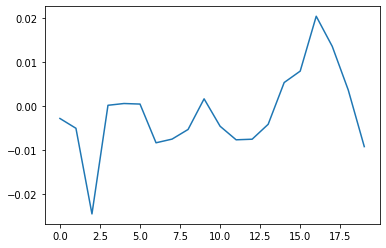

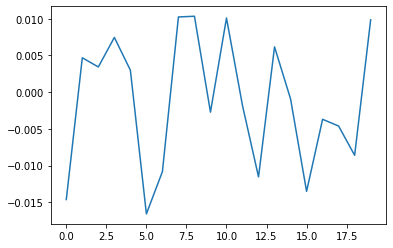

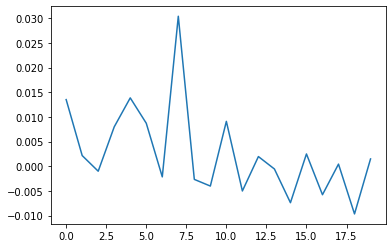

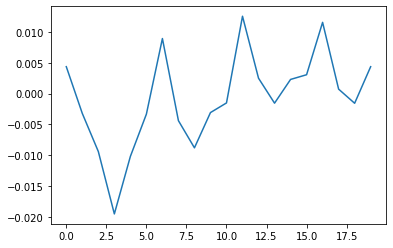

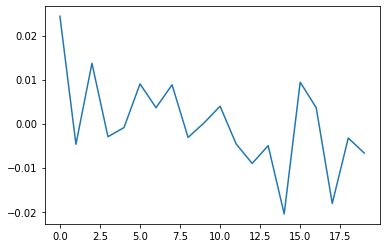

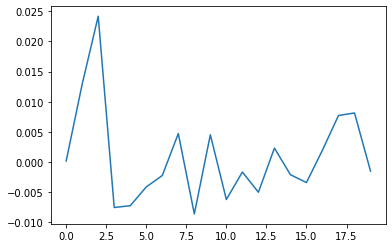

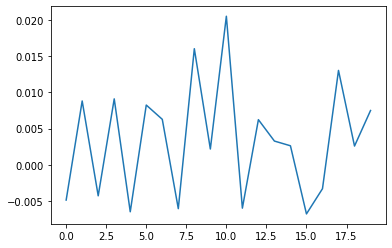

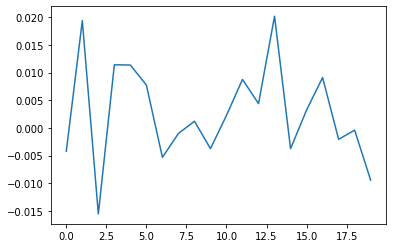

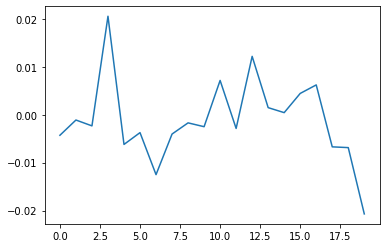

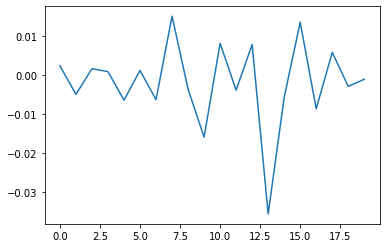

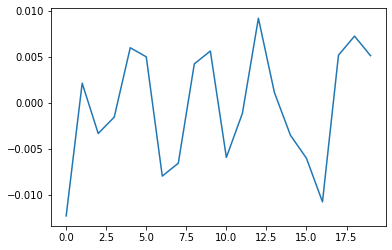

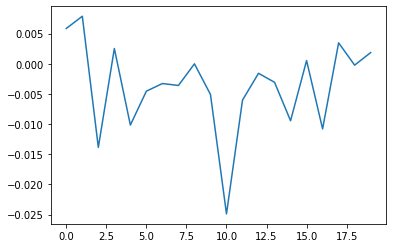

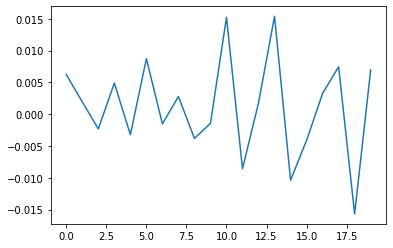

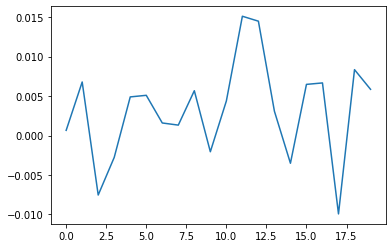

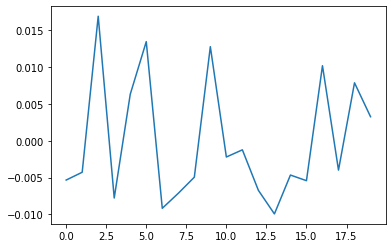

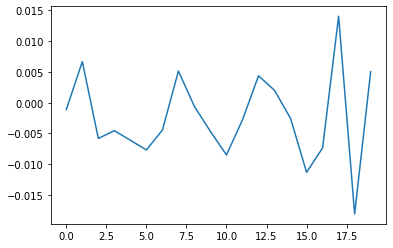

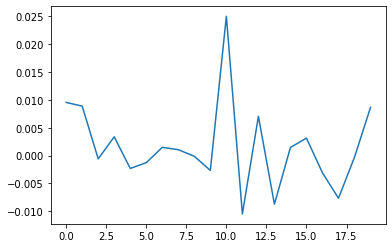

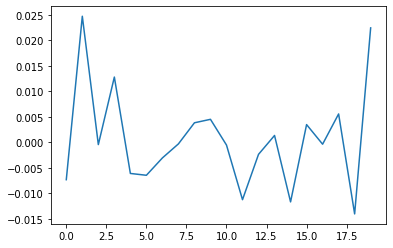

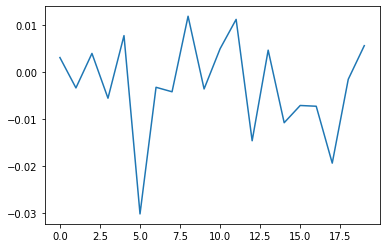

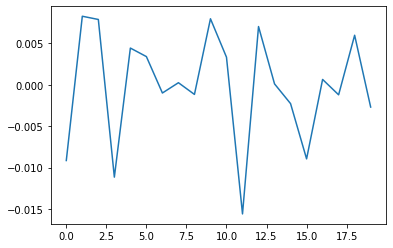

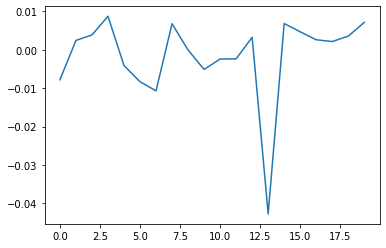

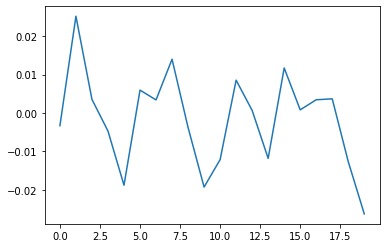

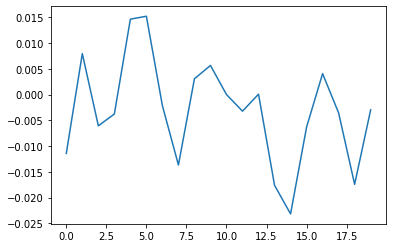

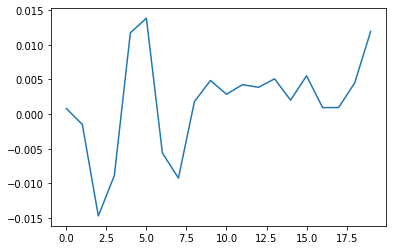

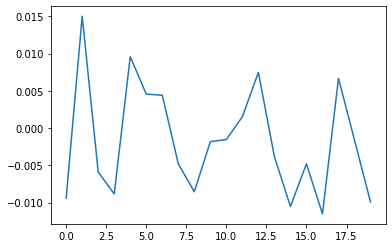

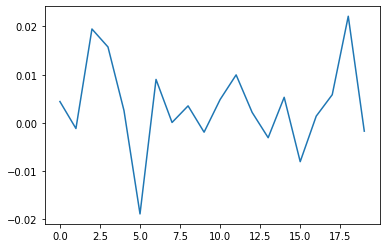

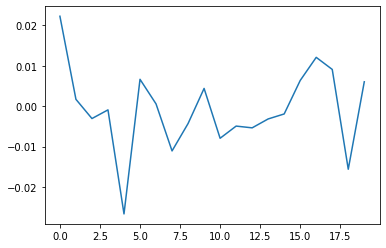

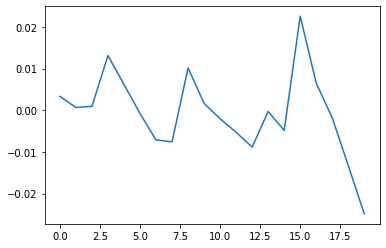

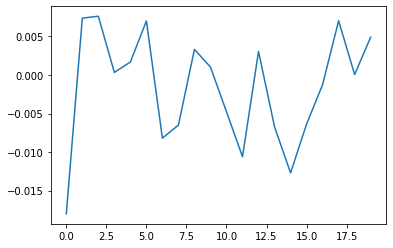

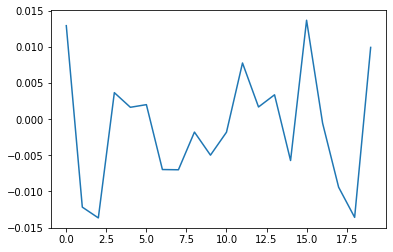

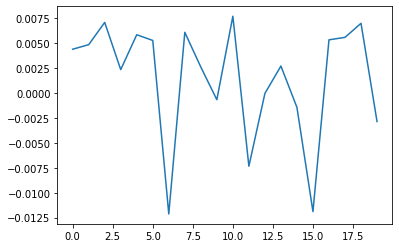

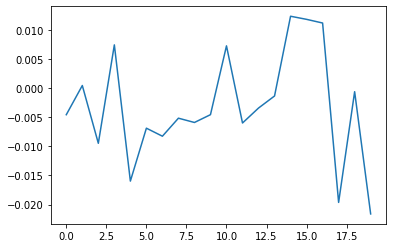

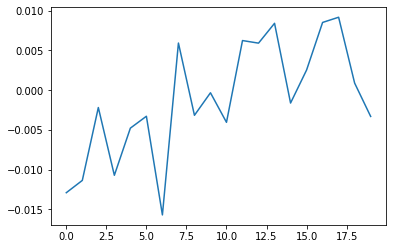

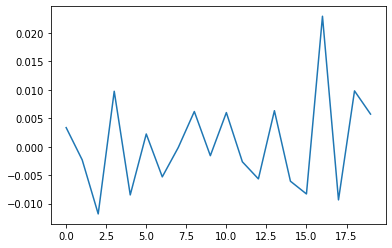

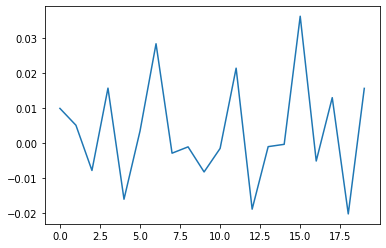

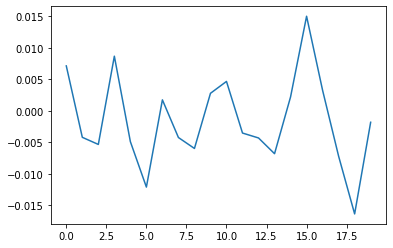

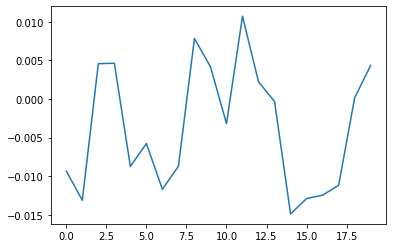

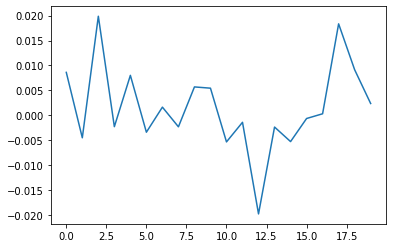

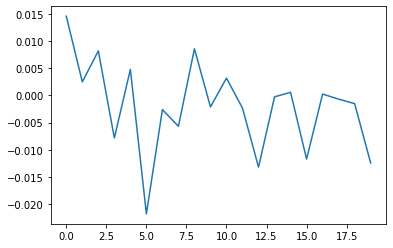

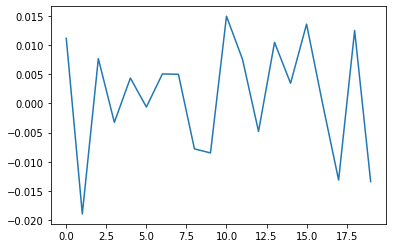

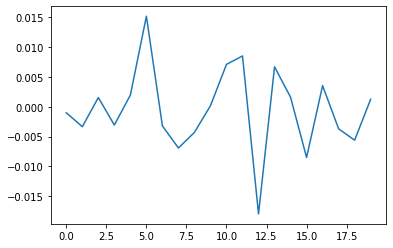

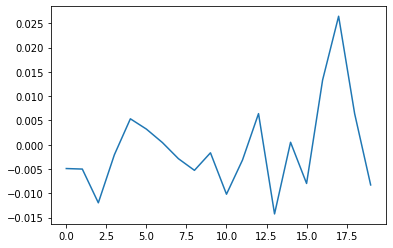

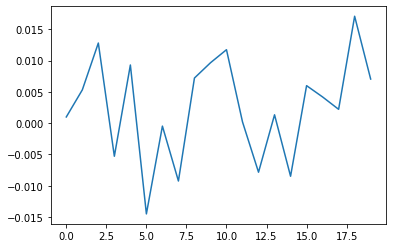

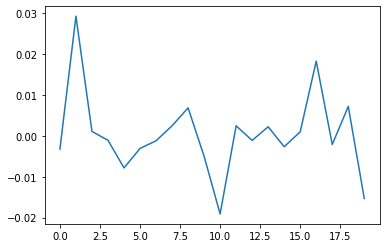

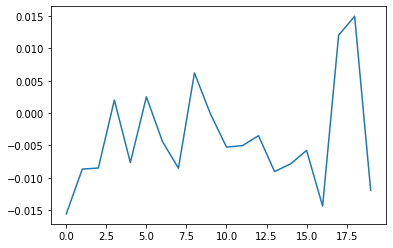

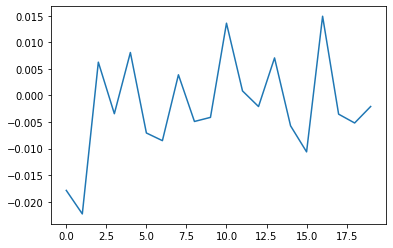

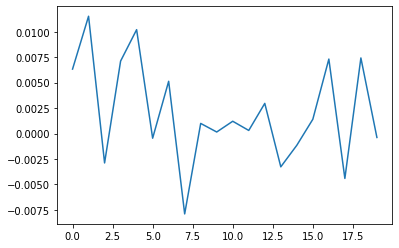

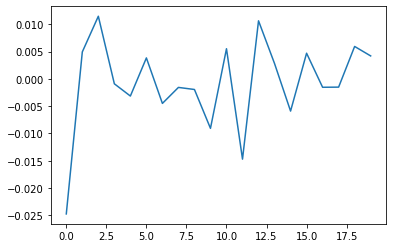

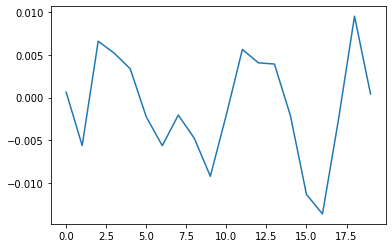

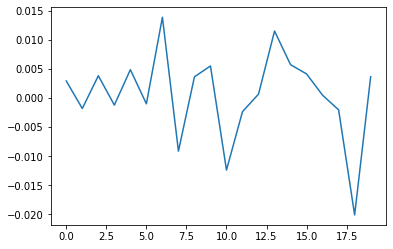

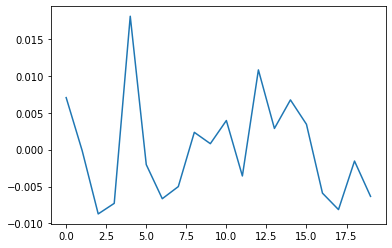

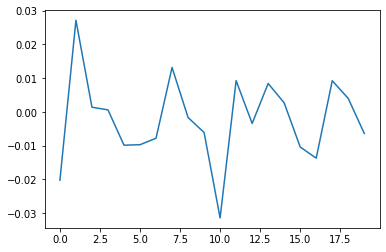

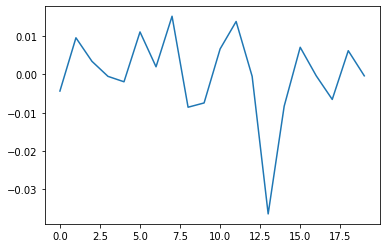

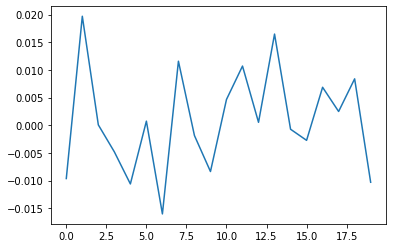

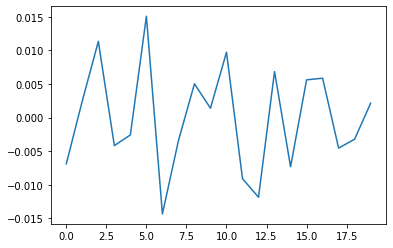

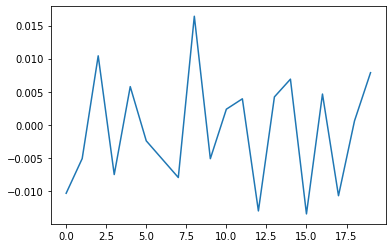

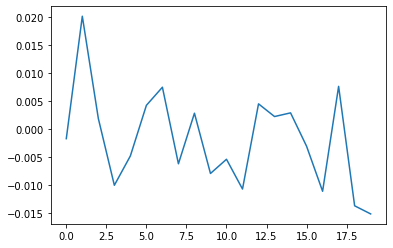

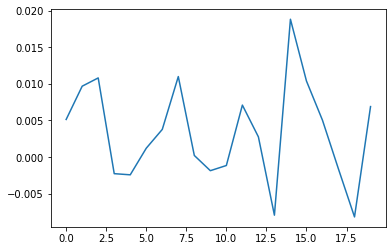

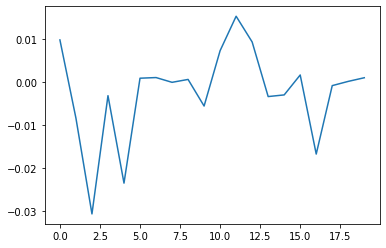

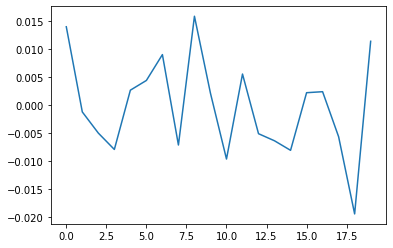

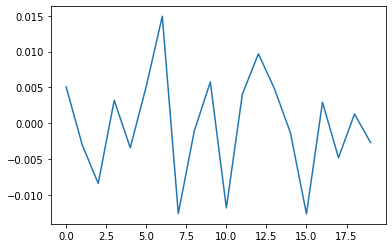

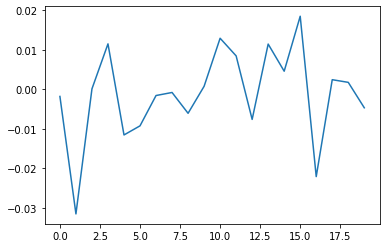

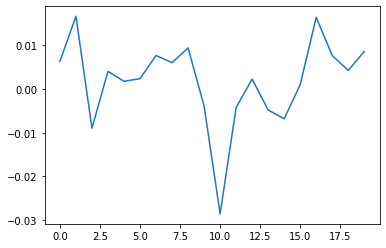

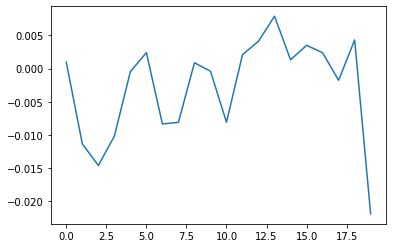

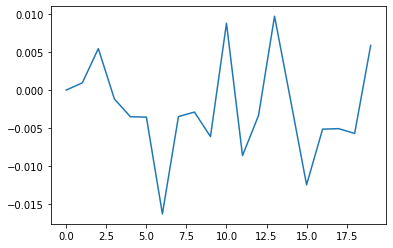

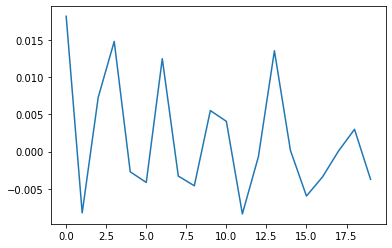

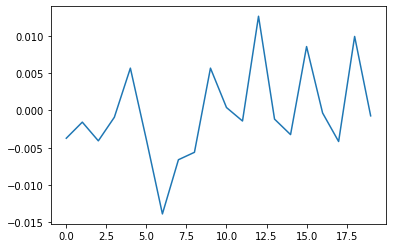

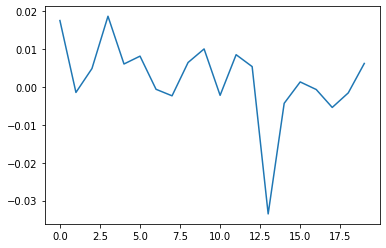

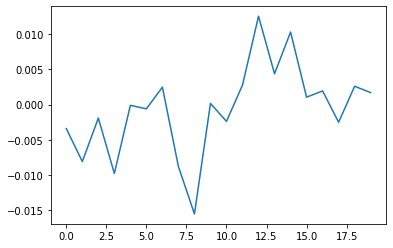

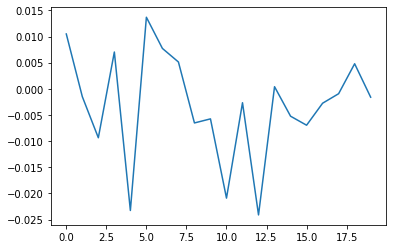

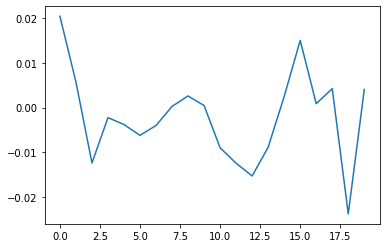

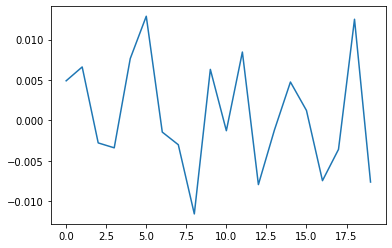

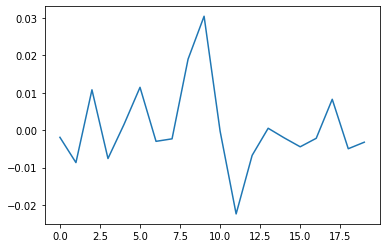

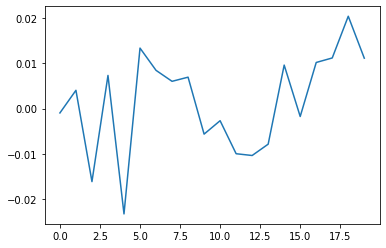

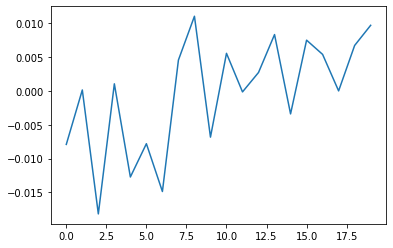

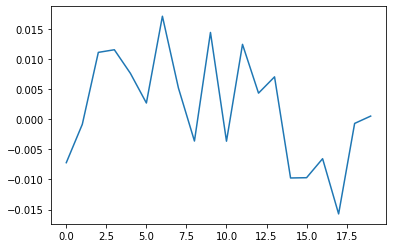

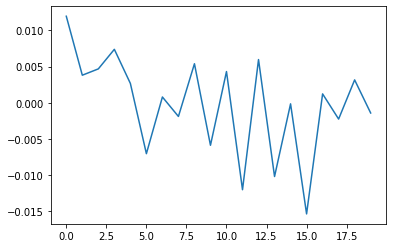

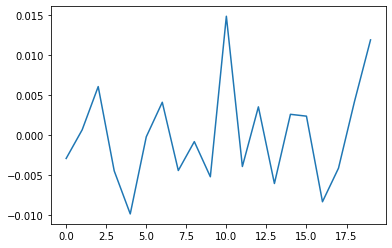

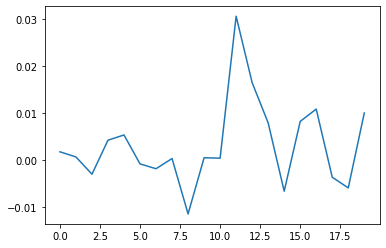

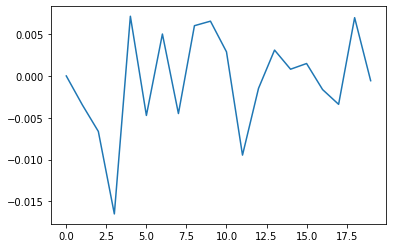

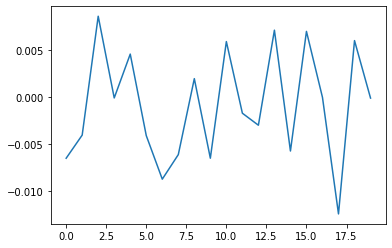

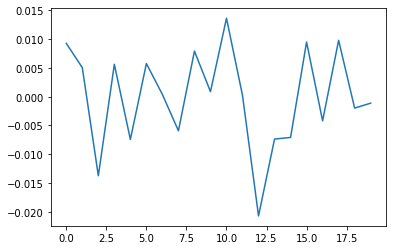

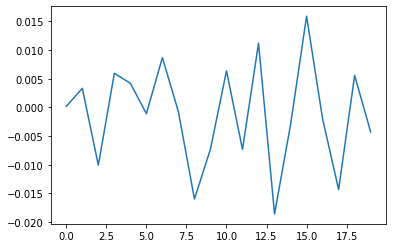

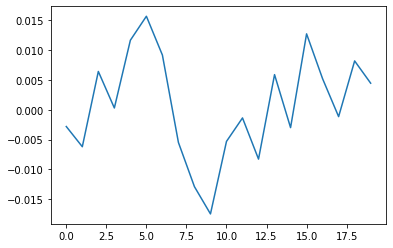

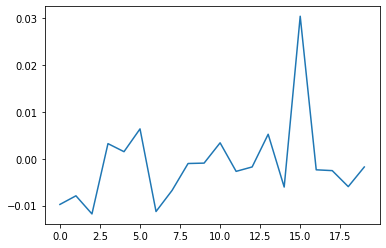

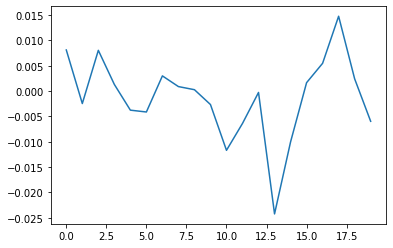

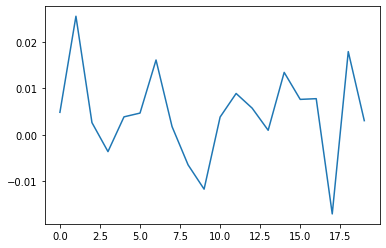

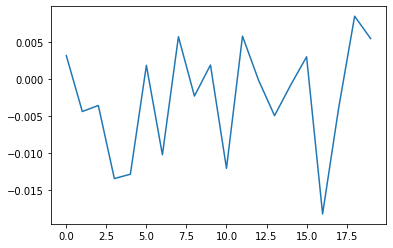

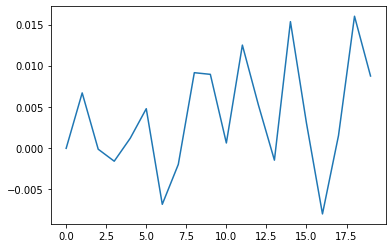

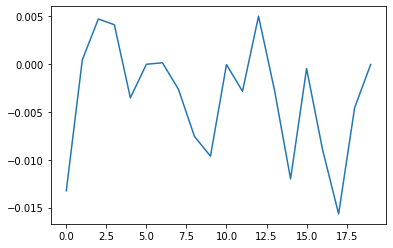

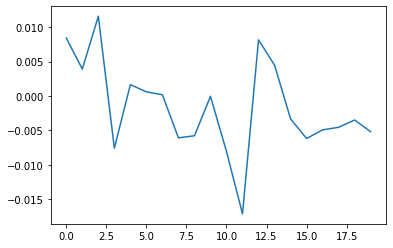

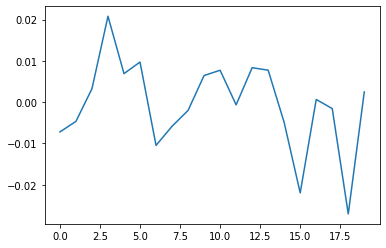

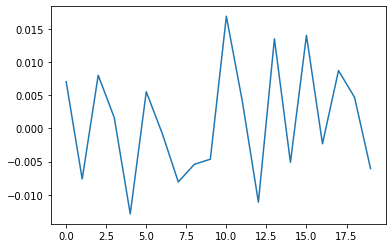

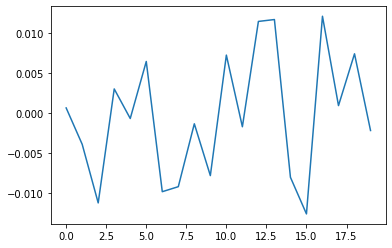

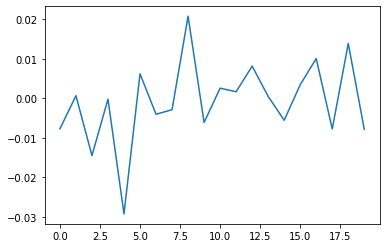

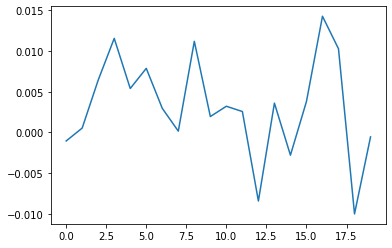

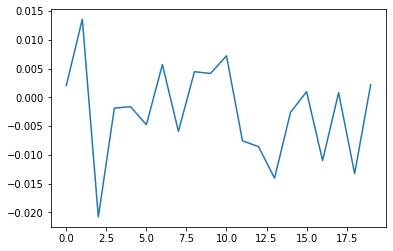

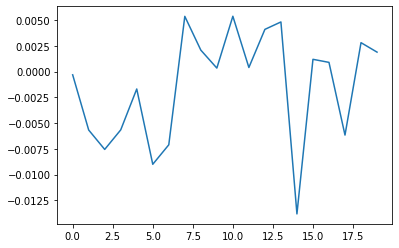

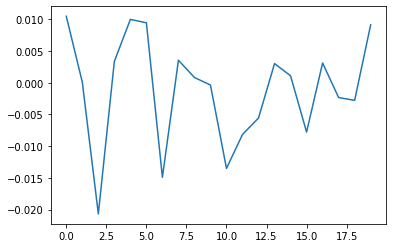

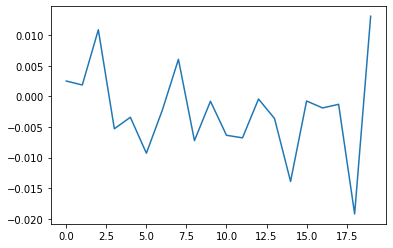

In [116]:
for i in range(100):
    plt.plot(feat_val[i,:])
    plt.show()
    

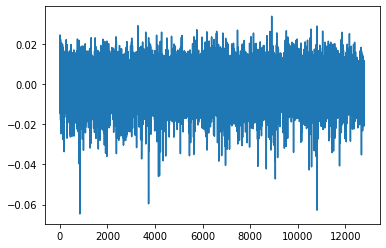

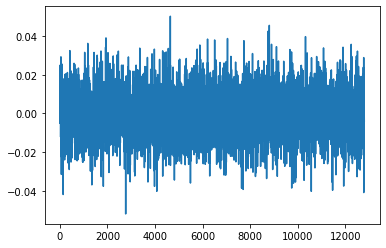

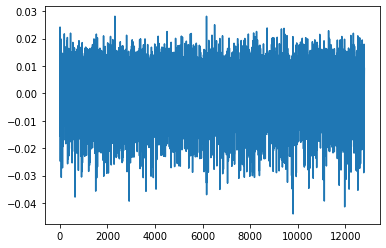

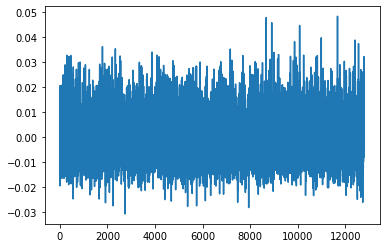

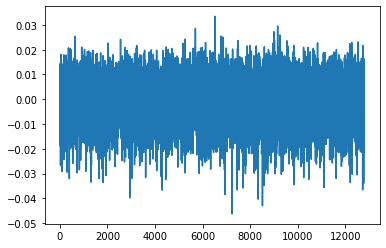

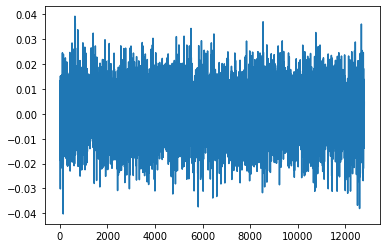

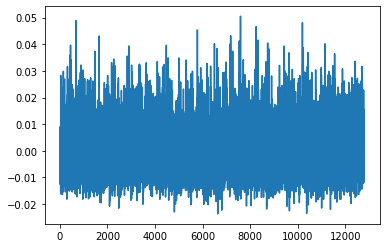

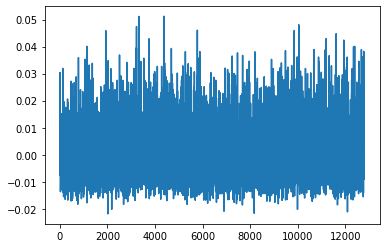

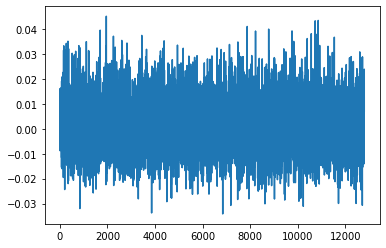

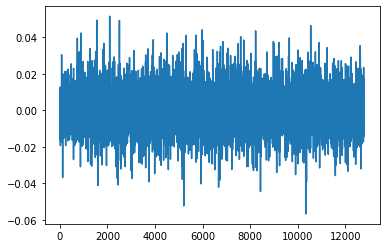

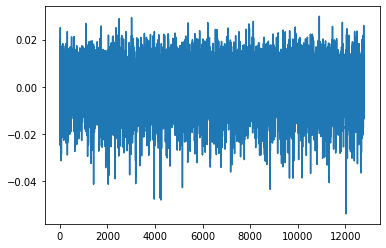

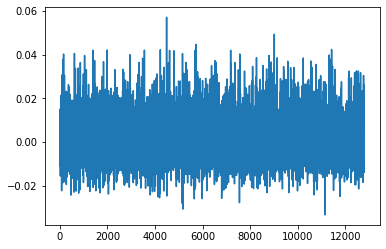

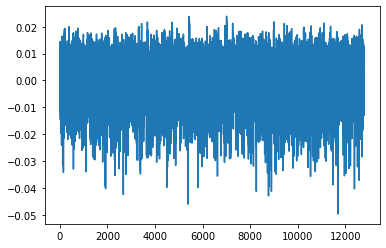

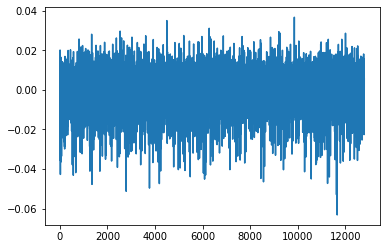

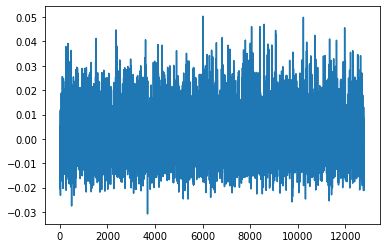

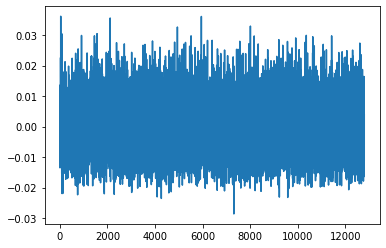

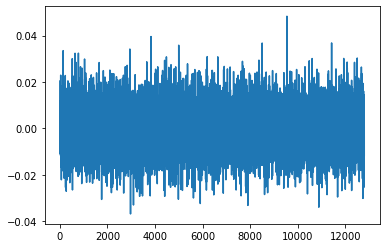

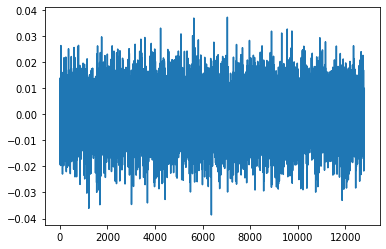

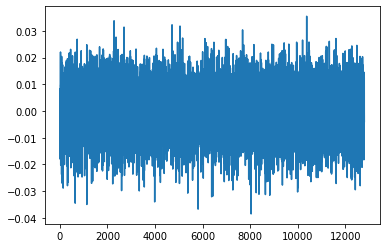

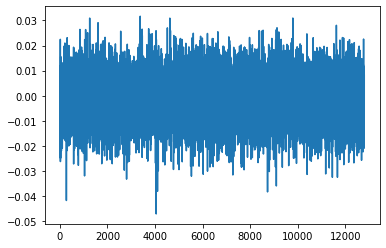

In [118]:
for i in range(feat_val.shape[1]):
    plt.plot(feat_val[:,i])
    plt.show()

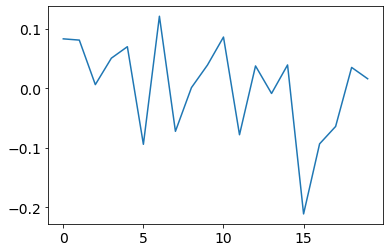

In [248]:
plt.plot(feat_val[1])

In [119]:
def showmat(X, xlabel=None, ylabel=None, fontsize=14, crange=None, figsize=None):

    # Prepare plot data ---------------------------------------
    if figsize is None:
        figsize = [1, 1]
    X = X.copy()
    if len(X.shape) > 2:
        print("X has to be matrix or vector")
        return

    if X.shape[0]==1 or X.shape[1]==1:
        Nsize = X.size
        X = X.reshape(np.sqrt(Nsize), np.sqrt(Nsize))

    # Plot ----------------------------------------------------
    fig = plt.figure(figsize=(8*figsize[0], 6*figsize[1]))

    plt.imshow(X,interpolation='none',aspect='auto')
    plt.colorbar()

    # Color range
    if not(crange is None):
        if len(crange)==2:
            plt.clim(crange[0], crange[1])

        elif crange == "maxabs":
            xmaxabs = np.absolute(X).max()
            plt.clim(-xmaxabs, xmaxabs)

    if not(xlabel is None):
        plt.xlabel(xlabel)
    if not(ylabel is None):
        plt.ylabel(ylabel)

    plt.rcParams["font.size"] = fontsize

    plt.ion()
    plt.show()
    plt.pause(0.001)


# =============================================================
# showtimedata
# =============================================================
def showtimedata(X, xlabel="Time", ylabel="Channel", fontsize=14, linewidth=1.5,
                 intervalstd=10, figsize=None):

    # Prepare plot data ---------------------------------------
    if figsize is None:
        figsize = [2, 1]
    X = X.copy()
    X = X.reshape([X.shape[0],-1])

    if X.shape[1]==1:
        X = X.reshape([1,-1])

    Nch = X.shape[0]
    Nt = X.shape[1]

    vInterval = X.std(axis=1).max() * intervalstd
    vPos = vInterval * (np.arange(Nch,0,-1) - 1)
    vPos = vPos.reshape([1, -1]).T  # convert to column vector
    X = X + vPos

    # Plot ----------------------------------------------------
    fig = plt.figure(figsize=(8*figsize[0], 6*figsize[1]))

    for i in range(Nch):
        plt.plot(list(range(Nt)), X[i,:], linewidth=linewidth)

    plt.xlim(0, Nt-1)
    plt.ylim(X.min(),X.max())

    ylabels = [str(num) for num in range(Nch)]
    plt.yticks(vPos,ylabels)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.rcParams["font.size"] = fontsize

    plt.ion()
    plt.show()
    plt.pause(0.001)

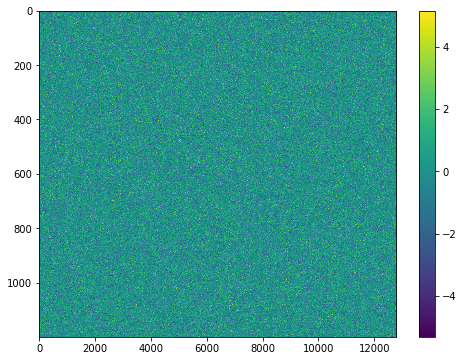

In [120]:
showmat(sensor)

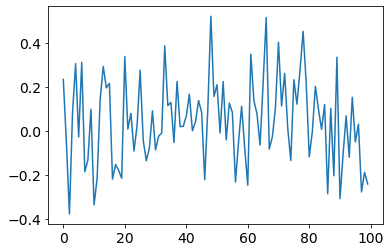

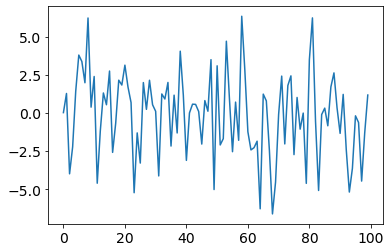

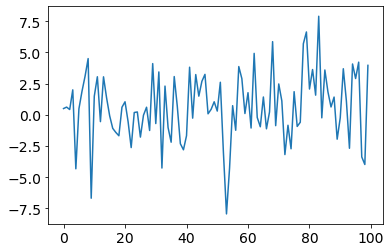

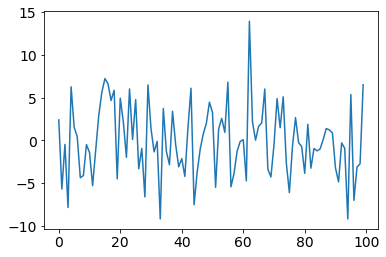

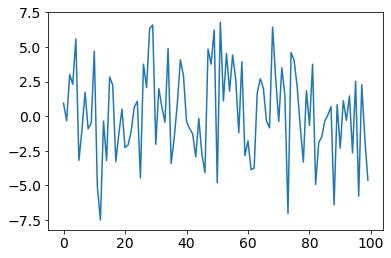

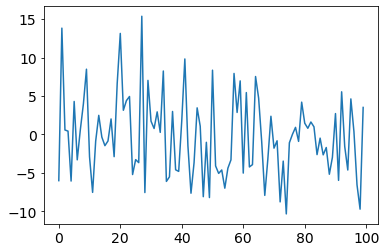

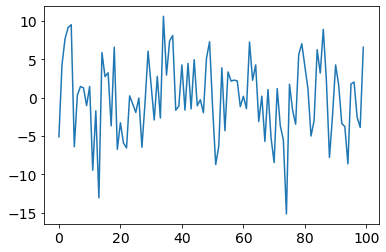

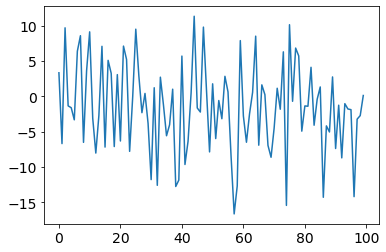

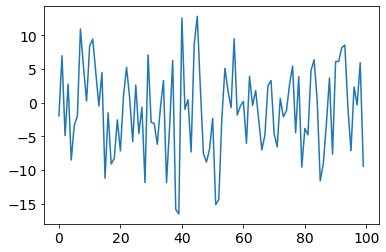

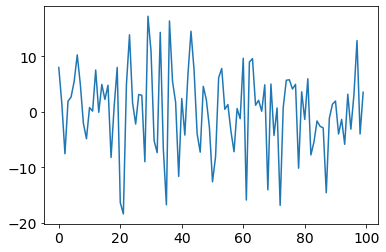

In [50]:
for i in range(10):
    plt.plot(sensor[i,:100])
    plt.show()

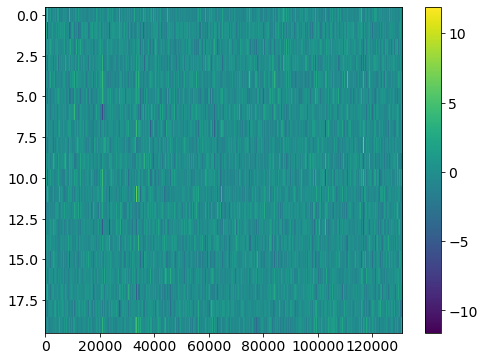

In [181]:
showmat(sensor)

TypeError: unhashable type: 'numpy.ndarray'

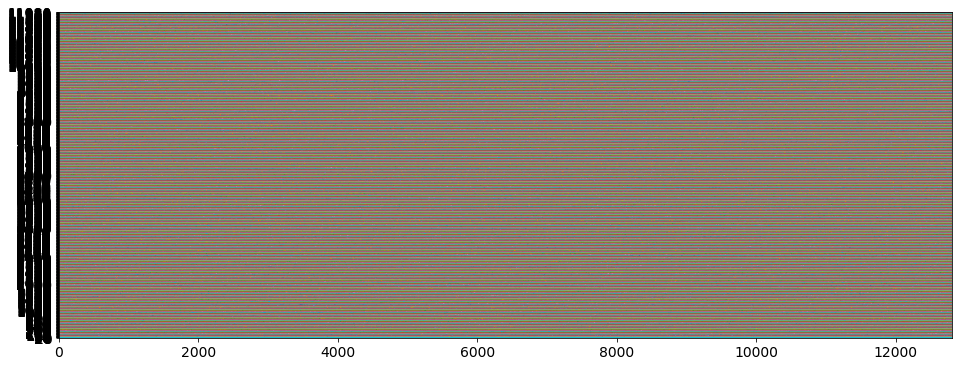

In [121]:
showtimedata(sensor)

In [219]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [220]:
df_train

freqs    pivots   pattern
0    [0.8689888988458878, 0.8958279698282763, 0.939...  [37, 71]      down
1    [0.6101704271965991, 1.0, 0.3466734571767951, ...        []    stable
2    [0.2681537489101373, 0.7621964903916272, 0.109...        []    stable
3    [0.1475031771881632, 0.022291642330893646, 0.1...  [43, 70]        up
4    [0.0497241524734473, 0.14013812083883814, 0.24...  [51, 55]  spike_up
..                                                 ...       ...       ...
995  [0.01635650881722639, 0.057098616610909536, 0....  [59, 92]   up_down
996  [0.8963000843625984, 0.9394662894535663, 0.999...   [8, 98]      down
997  [1.0, 0.17636598190884278, 0.40881447525363335...        []    stable
998  [0.895537241542786, 0.8950396177818458, 0.9614...  [69, 81]   down_up
999  [0.9211277278464715, 0.8442416637482625, 0.951...  [37, 96]      down

[1000 rows x 3 columns]

In [221]:
X = np.array(df_train["freqs"].values.tolist())

In [229]:
a = np.array(df_train["pattern"].values.tolist())
b, y = np.unique(a, return_inverse=True)

In [232]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.15)

In [239]:
lsvc = LinearSVC(max_iter=10000)

In [240]:
lsvc.fit(xtrain, ytrain)
score = lsvc.score(xtrain, ytrain)
print("Score: ", score)

Score:  0.9788235294117648


In [241]:
cv_scores = cross_val_score(lsvc, xtrain, ytrain, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.80


In [242]:
ypred = lsvc.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

[[21  0  0  0  0  0  0]
 [ 0 13  2  0  0  0  0]
 [ 0  1  9  0  1  0  0]
 [ 0  0  0 11  1  0  0]
 [ 1  3  2  1 49  3  1]
 [ 0  0  0  0  0 16  0]
 [ 0  0  0  5  0  0 10]]


In [249]:
cr = classification_report(ytest, ypred)
print(cr) 

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       0.76      0.87      0.81        15
           2       0.69      0.82      0.75        11
           3       0.65      0.92      0.76        12
           4       0.96      0.82      0.88        60
           5       0.84      1.00      0.91        16
           6       0.91      0.67      0.77        15

    accuracy                           0.86       150
   macro avg       0.82      0.87      0.84       150
weighted avg       0.88      0.86      0.86       150



In [245]:
test_score = lsvc.score(xtest, ytest)
print("Test score: ", test_score)

Test score:  0.86


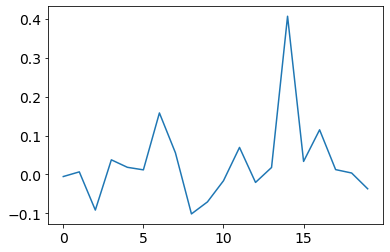

In [258]:
plt.plot(feat_val[3,:])

In [259]:
print(lsvc.predict(feat_val[3,:].reshape(1, -1)))

ValueError: X has 20 features per sample; expecting 100